# Visualize CMIP6 model trend variability data

I have now pre-processed the gridded monthly model output into trends for CESM1 PI-Control simulation.

For now, I will create my code for the CESM1 and MPI models so that it can be generalized easily. I can pull some code from my climatetrend_uncertainty repository (climatetrend_uncertainty/initial_code/PIC_timeseries_preproc.ipynb).

__I am going to visualize the trend uncertainty from climate variability now.__

## Code

In [1]:
import sys,warnings
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/Common/')

from imports import (
    np, xr, plt, sns, os,
    glob, dask
    )

%matplotlib inline

### Load processed trend data

#### Models

In [2]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
pic_tseries_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/'
cesm1_dir       = 'CESM1/'
mpi_dir         = 'MPI-GE/'
canesm2_dir     = 'CanESM2/'
esm2m_dir       = 'ESM2M/'

cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

In [3]:
cesm1_trends_filepath   = glob.glob('%s/%s/*trends*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_trends_filepath     = glob.glob('%s/%s/*trends*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_trends_filepath = glob.glob('%s/%s/*trends*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_trends_filepath   = glob.glob('%s/%s/*trends*.nc' % (pic_tseries_dir,esm2m_dir))

Load the trend data.

In [4]:
cesm1_pic_trends_all   = xr.open_dataarray(*cesm1_trends_filepath)

mpi_pic_trends_all     = xr.open_dataarray(*mpi_trends_filepath)

canesm2_pic_trends_all = xr.open_dataarray(*canesm2_trends_filepath)

esm2m_pic_trends_all   = xr.open_dataarray(*esm2m_trends_filepath)

#### Observations

In [5]:
obs_tseries_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS/'
gistemp_2x2_dir = 'GISTEMP_2x2/'
gistemp_5x5_dir = 'GISTEMP_5x5/'
hadcrut5_dir    = 'HadCRUT5/'

In [6]:
gistemp_tas_var = 'tempAnom'
hadcrut5_tas_var = 'tas'

In [7]:
gistemp_2x2_trends_filepath  = glob.glob('%s/%s/*trends*.nc' % (obs_tseries_dir,gistemp_2x2_dir))
gistemp_5x5_trends_filepath  = glob.glob('%s/%s/*trends*.nc' % (obs_tseries_dir,gistemp_5x5_dir))
hadcrut5_trends_filepath     = glob.glob('%s/%s/*trends*.nc' % (obs_tseries_dir,hadcrut5_dir))

Load the trend data

In [8]:
gistemp_2x2_trends_all  = xr.open_dataarray(*gistemp_2x2_trends_filepath)

gistemp_5x5_trends_all  = xr.open_dataarray(*gistemp_5x5_trends_filepath)

hadcrut5_trends_all     = xr.open_dataarray(*hadcrut5_trends_filepath)

### Define functions

In [9]:
# These functions allow me to calculate a percentile across all variables for each month of the year. 
# Essentially a poorman's version of creating the numpy.percentile function within xarray. But it works!

def xr_percentile_wrapper(nparray,q,axis):
    '''
    Wrapper for a non-xarray function so that it returns a DataArray object.
    I am using nanpercentile here because it handles all cases.
    '''
    return xr.DataArray(np.nanpercentile(nparray,q=q,axis=axis))

def percentile_monthly_wrapper(data,dim,q,axis):
    
    return data.groupby(dim).map(xr_percentile_wrapper,q=q,axis=axis)

In [10]:
def percentile_vec(data,core_dim:str,q,**kwargs):
    
    data_chunk = data.chunk({core_dim:-1}) # needed!

    res_out = xr.apply_ufunc(np.nanpercentile,              # Function to apply
                             data_chunk,                      # Positional arguments for the function
                             input_core_dims=[[core_dim]],    # Dimension(s) to apply the function over
                             kwargs={**{'q':q}, **kwargs},                   # Keyword arguments for the function
                             # kwargs=kwargs,                   # Keyword arguments for the function
                             dask="parallelized",             # These may be necessary for efficient use via dask.
                             output_dtypes=['float64'],
                             vectorize = True)                # Vectorize
    
    return res_out


# You can also do this in numpy if you are ok converting back to xarray
# out_np = np.nanpercentile(data,q=95,axis=1,keepdims=False)

### Visualize different standard deviations for different regions.

#### Models

In [11]:
cesm1_pic_trends_std   = cesm1_pic_trends_all.std(dim='startyear',skipna=True)

mpi_pic_trends_std     = mpi_pic_trends_all.std(dim='startyear',skipna=True)

canesm2_pic_trends_std = canesm2_pic_trends_all.std(dim='startyear',skipna=True)

esm2m_pic_trends_std   = esm2m_pic_trends_all.std(dim='startyear',skipna=True)

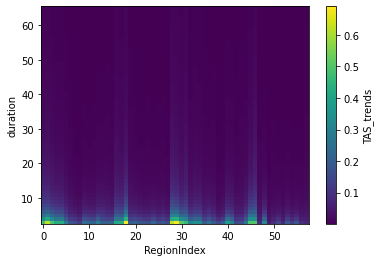

In [12]:
cesm1_pic_trends_std.plot()

Text(0.5, 0.9, 'CESM1 Variability')

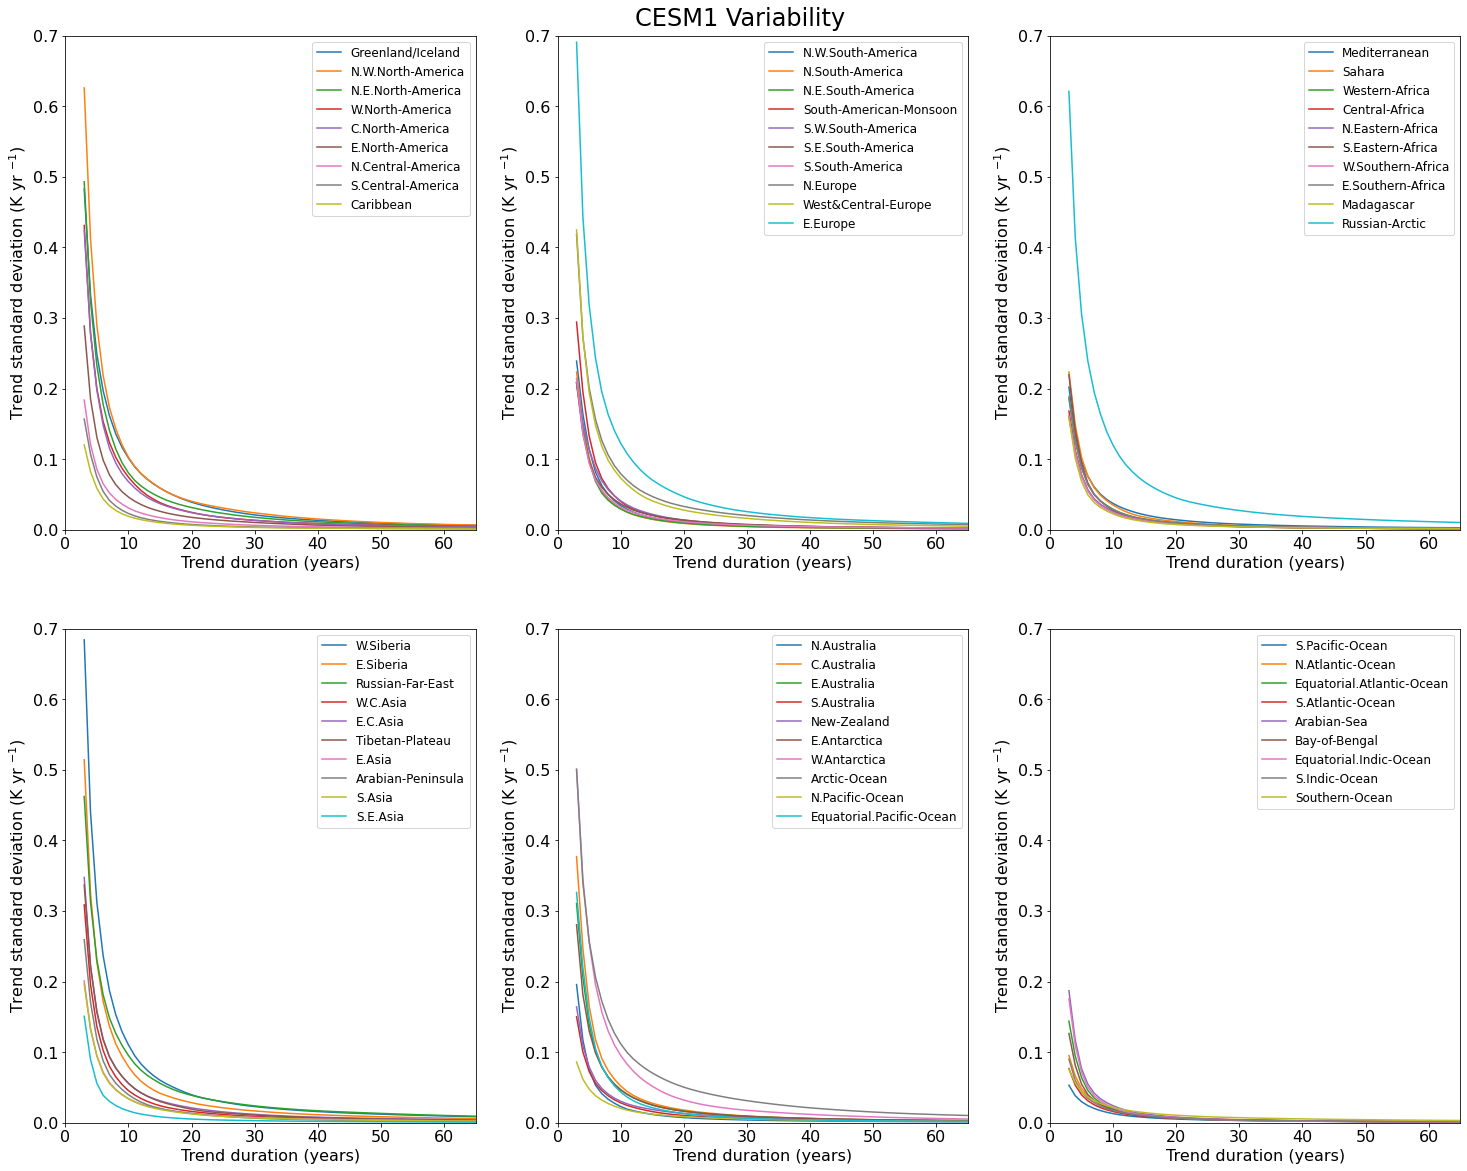

In [13]:
fig,axs = plt.subplots(2,3,figsize=(25,20))
axs = axs.flat

ax_i = 0
for i in cesm1_pic_trends_std.RegionIndex:
    
    if (i+1) % 10 == 0: ax_i += 1 # Only put 10 regions per panel
    # if i > 9: ax_i += 1 # Only put 10 regions per panel
    
    _data = cesm1_pic_trends_std.sel(RegionIndex=i)
    
    axs[ax_i].plot(_data.duration,_data,label=str(_data.RegionName.values))
    
    axs[ax_i].set_xlabel('Trend duration (years)',fontsize=16)
    axs[ax_i].set_ylabel('Trend standard deviation (K yr $^{-1}$)',fontsize=16)
    axs[ax_i].tick_params(labelsize=16)
    
    axs[ax_i].set_xlim(0,65)
    axs[ax_i].set_ylim(0,0.7)
    
    axs[ax_i].legend(fontsize=12)
    
fig.suptitle('CESM1 Variability',fontsize=24,x=0.5,y=0.90)

Text(0.5, 0.9, 'MPI-GE Variability')

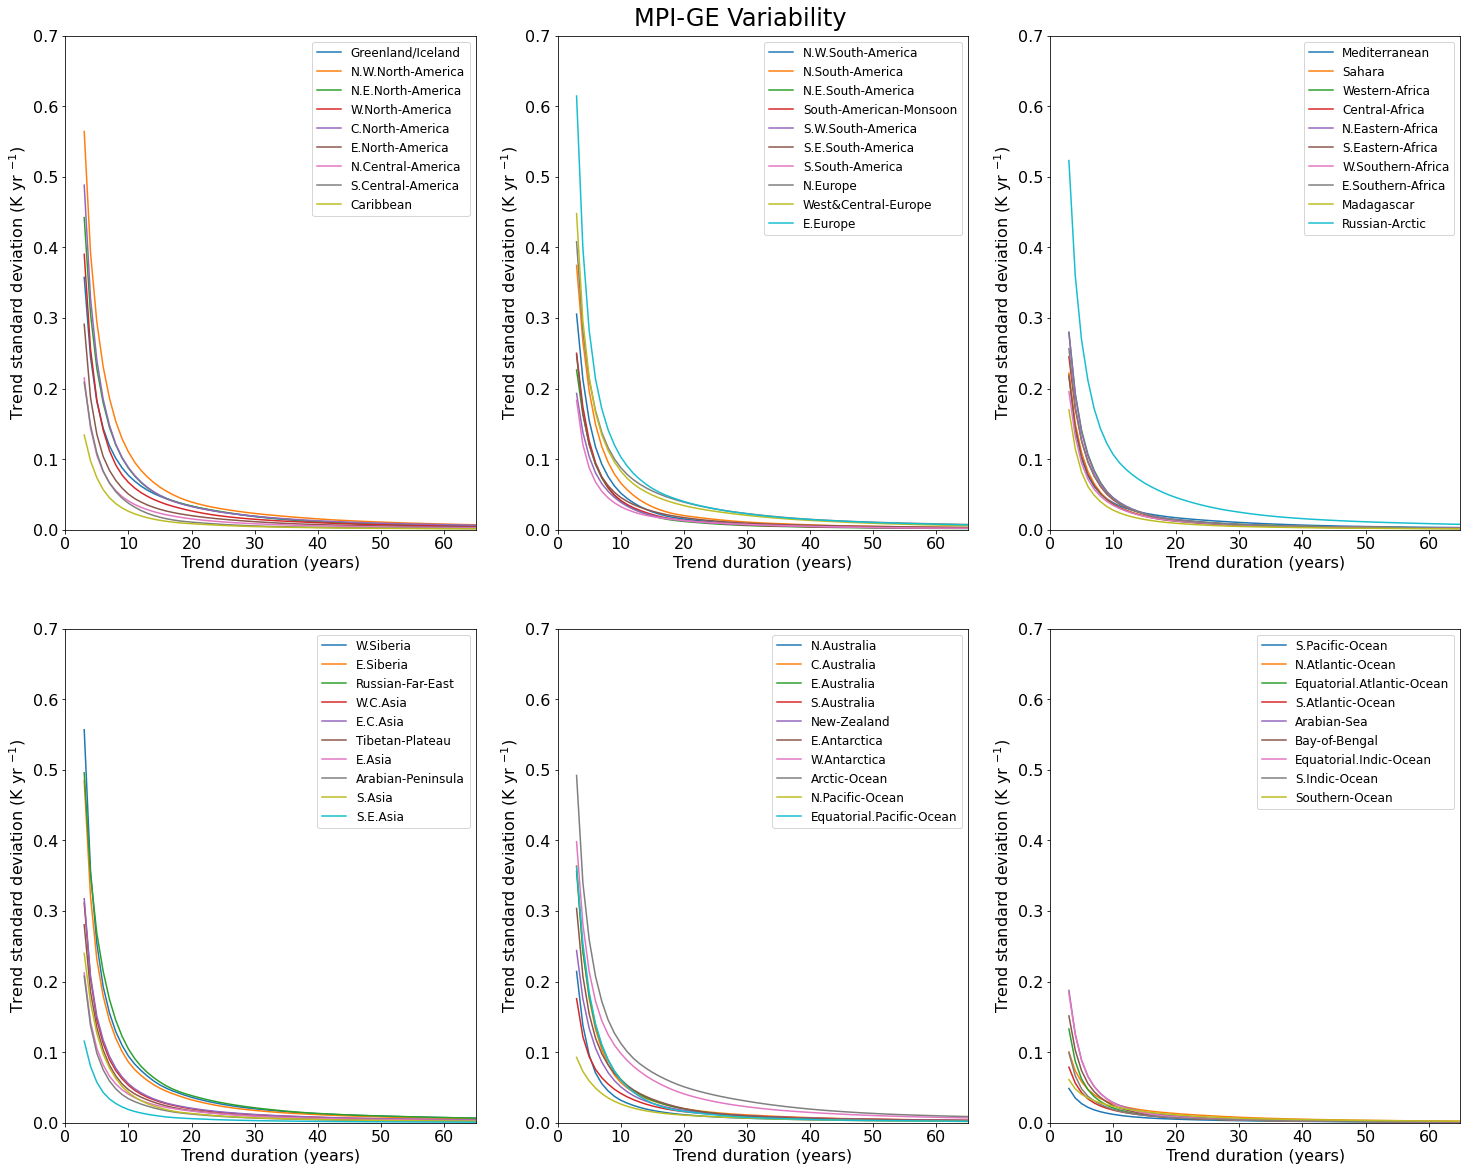

In [14]:
fig,axs = plt.subplots(2,3,figsize=(25,20))
axs = axs.flat

ax_i = 0
for i in mpi_pic_trends_std.RegionIndex:
    
    if (i+1) % 10 == 0: ax_i += 1 # Only put 10 regions per panel
    # if i > 9: ax_i += 1 # Only put 10 regions per panel
    
    _data = mpi_pic_trends_std.sel(RegionIndex=i)
    
    axs[ax_i].plot(_data.duration,_data,label=str(_data.RegionName.values))
    
    axs[ax_i].set_xlabel('Trend duration (years)',fontsize=16)
    axs[ax_i].set_ylabel('Trend standard deviation (K yr $^{-1}$)',fontsize=16)
    axs[ax_i].tick_params(labelsize=16)
    
    axs[ax_i].set_xlim(0,65)
    axs[ax_i].set_ylim(0,0.7)
    
    axs[ax_i].legend(fontsize=12)
    
fig.suptitle('MPI-GE Variability',fontsize=24,x=0.5,y=0.90)

Text(0.5, 0.9, 'CanESM2 Variability')

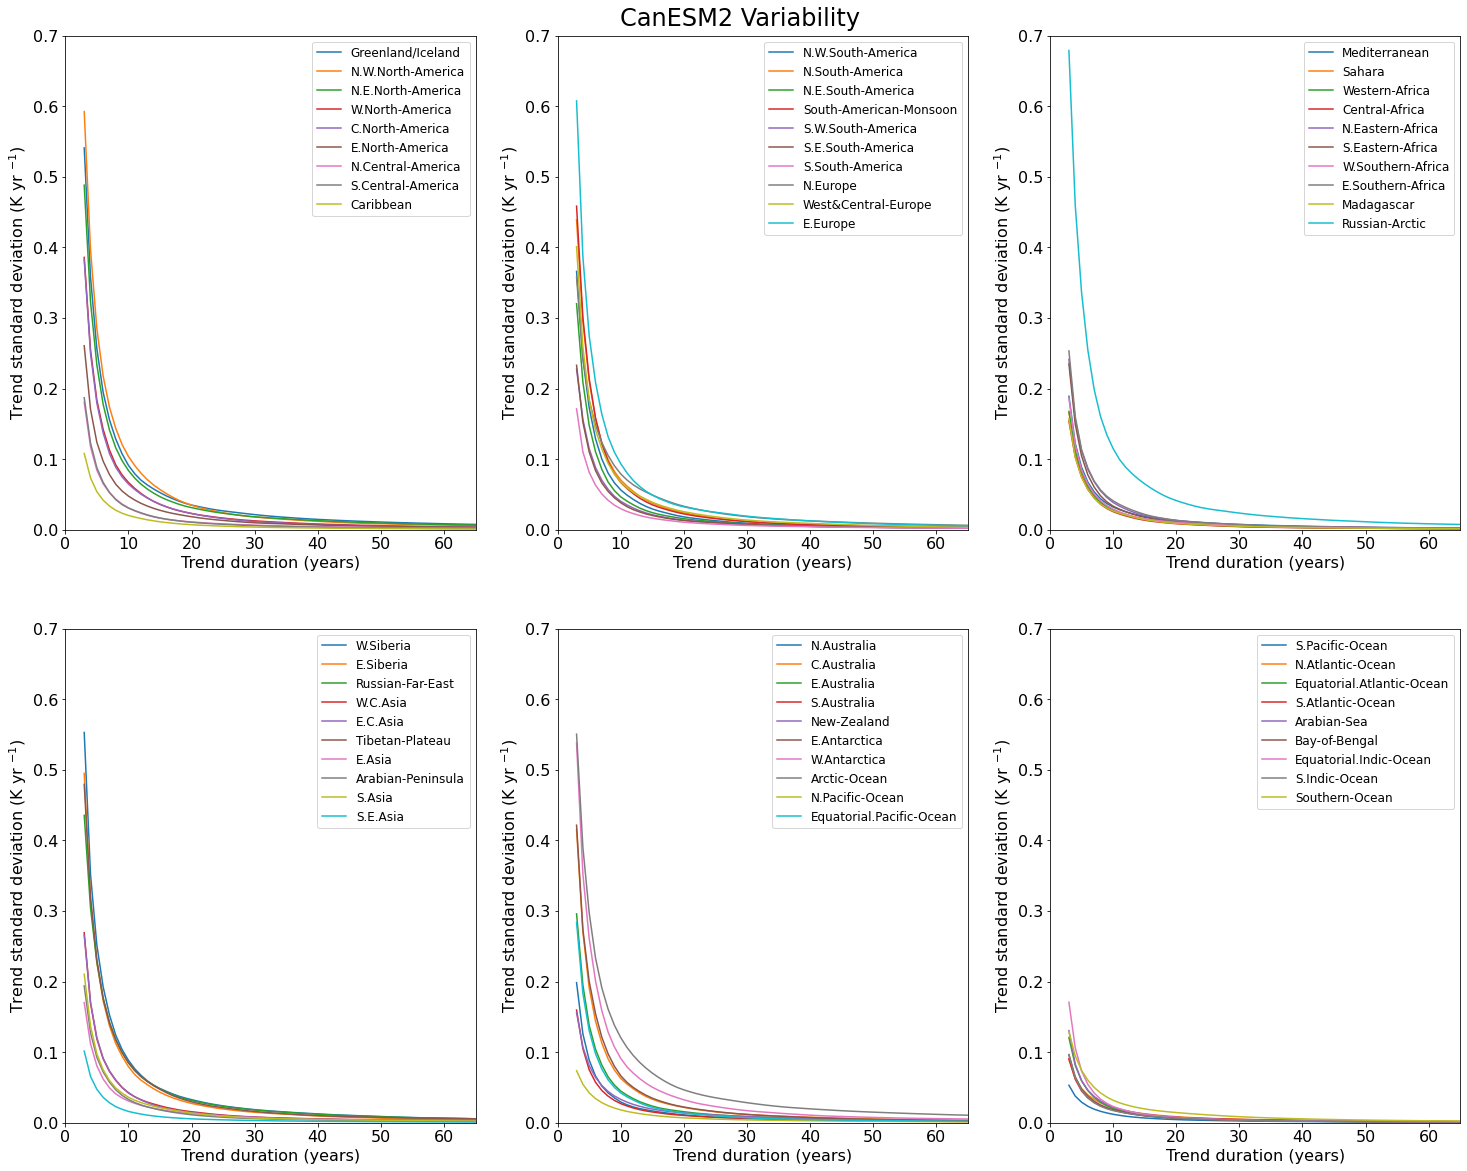

In [15]:
fig,axs = plt.subplots(2,3,figsize=(25,20))
axs = axs.flat

ax_i = 0
for i in canesm2_pic_trends_std.RegionIndex:
    
    if (i+1) % 10 == 0: ax_i += 1 # Only put 10 regions per panel
    # if i > 9: ax_i += 1 # Only put 10 regions per panel
    
    _data = canesm2_pic_trends_std.sel(RegionIndex=i)
    
    axs[ax_i].plot(_data.duration,_data,label=str(_data.RegionName.values))
    
    axs[ax_i].set_xlabel('Trend duration (years)',fontsize=16)
    axs[ax_i].set_ylabel('Trend standard deviation (K yr $^{-1}$)',fontsize=16)
    axs[ax_i].tick_params(labelsize=16)
    
    axs[ax_i].set_xlim(0,65)
    axs[ax_i].set_ylim(0,0.7)
    
    axs[ax_i].legend(fontsize=12)
    
fig.suptitle('CanESM2 Variability',fontsize=24,x=0.5,y=0.90)

Text(0.5, 0.9, 'ESM2M Variability')

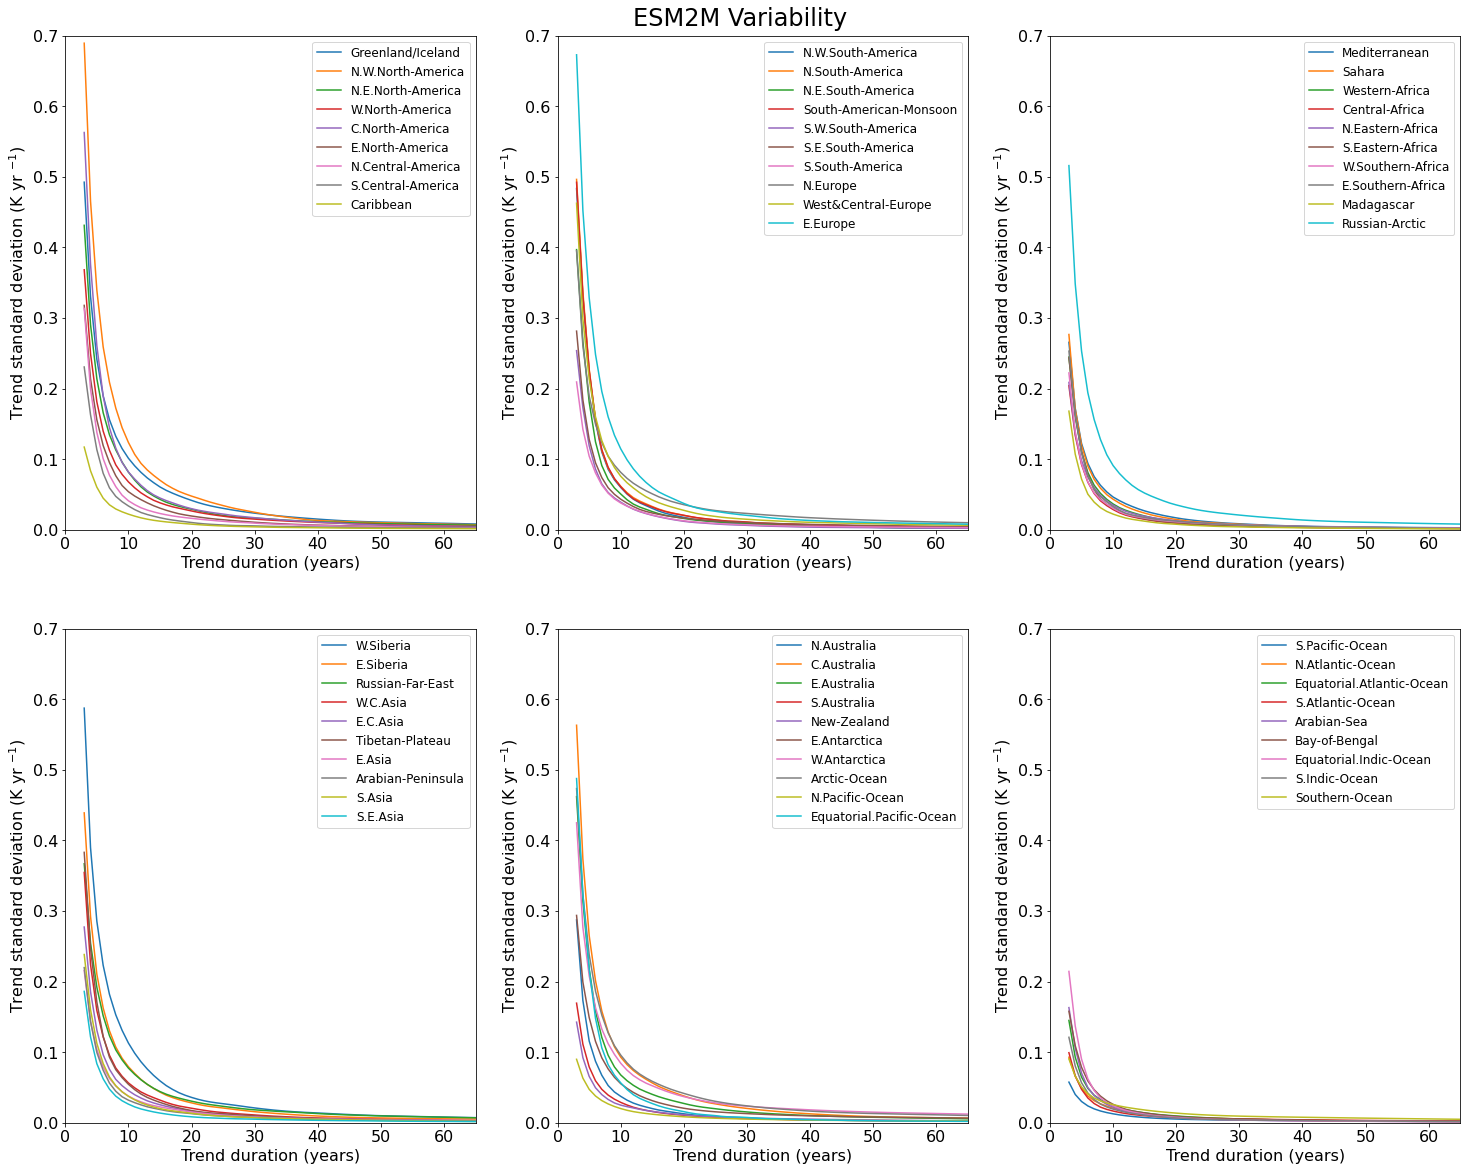

In [16]:
fig,axs = plt.subplots(2,3,figsize=(25,20))
axs = axs.flat

ax_i = 0
for i in esm2m_pic_trends_std.RegionIndex:
    
    if (i+1) % 10 == 0: ax_i += 1 # Only put 10 regions per panel
    # if i > 9: ax_i += 1 # Only put 10 regions per panel
    
    _data = esm2m_pic_trends_std.sel(RegionIndex=i)
    
    axs[ax_i].plot(_data.duration,_data,label=str(_data.RegionName.values))
    
    axs[ax_i].set_xlabel('Trend duration (years)',fontsize=16)
    axs[ax_i].set_ylabel('Trend standard deviation (K yr $^{-1}$)',fontsize=16)
    axs[ax_i].tick_params(labelsize=16)
    
    axs[ax_i].set_xlim(0,65)
    axs[ax_i].set_ylim(0,0.7)
    
    axs[ax_i].legend(fontsize=12)
    
fig.suptitle('ESM2M Variability',fontsize=24,x=0.5,y=0.90)

#### Observations

Here I am taking the standard deviation across realizations and using a single start year (1960).

In [17]:
gistemp_2x2_trends_std  = gistemp_2x2_trends_all.sel(startyear=1960).std(dim='record',skipna=True)

gistemp_5x5_trends_std  = gistemp_5x5_trends_all.sel(startyear=1960).std(dim='record',skipna=True)

hadcrut5_trends_std     = hadcrut5_trends_all.sel(startyear=1960).std(dim='realization',skipna=True)

In [18]:
del gistemp_2x2_trends_all,gistemp_5x5_trends_all,hadcrut5_trends_all

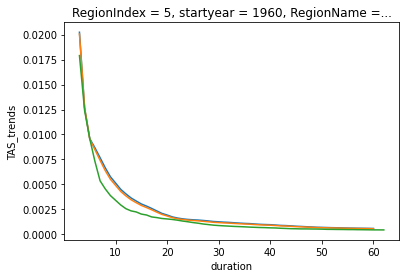

In [19]:
gistemp_2x2_trends_std.sel(RegionIndex=5).plot()

gistemp_5x5_trends_std.sel(RegionIndex=5).plot()

hadcrut5_trends_std.sel(RegionIndex=5).plot()

Ooh! Some interesting differences between the observational products here.

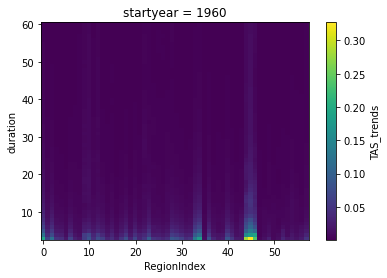

In [20]:
gistemp_2x2_trends_std.plot()

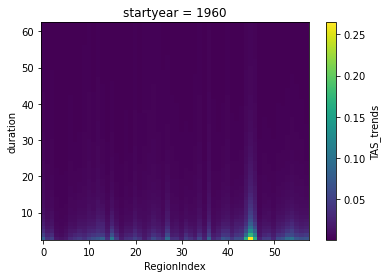

In [21]:
hadcrut5_trends_std.plot()

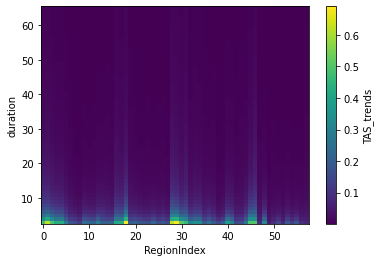

In [22]:
cesm1_pic_trends_std.plot()

Text(0.5, 0.9, 'GISTEMP 2x2 Variability')

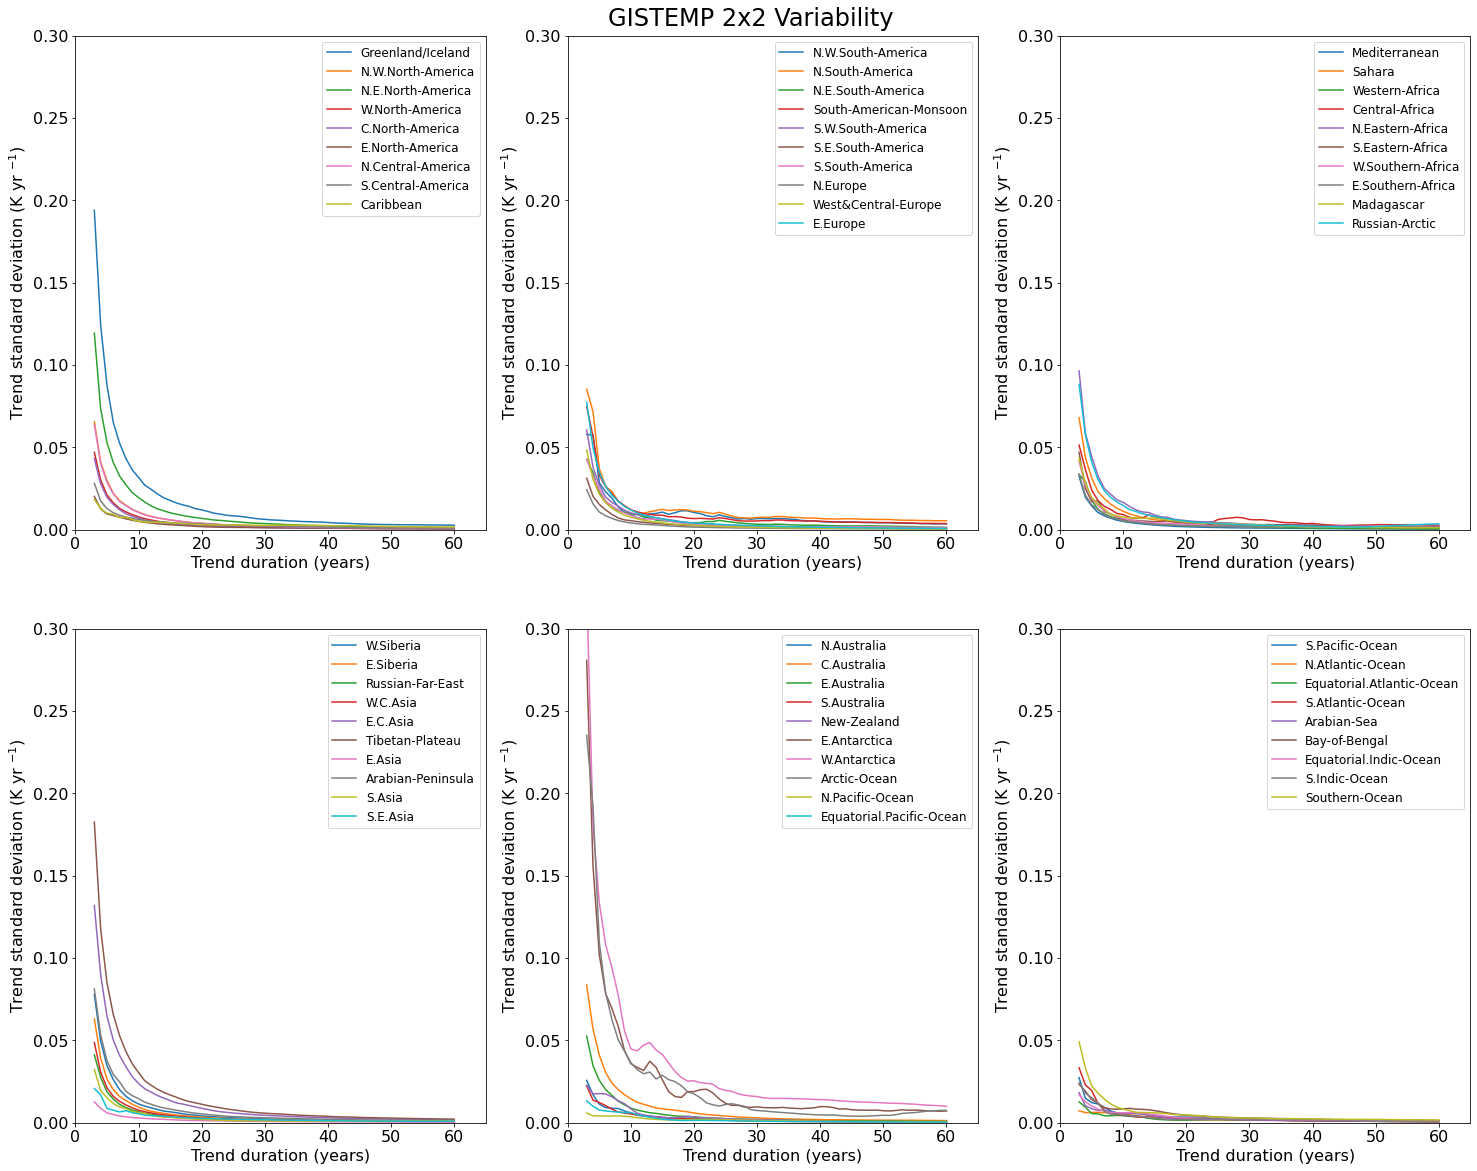

In [23]:
fig,axs = plt.subplots(2,3,figsize=(25,20))
axs = axs.flat

data = gistemp_2x2_trends_std

ax_i = 0
for i in data.RegionIndex:
    
    if (i+1) % 10 == 0: ax_i += 1 # Only put 10 regions per panel
    # if i > 9: ax_i += 1 # Only put 10 regions per panel
    
    _data = data.sel(RegionIndex=i)
    
    axs[ax_i].plot(_data.duration,_data,label=str(_data.RegionName.values))
    
    axs[ax_i].set_xlabel('Trend duration (years)',fontsize=16)
    axs[ax_i].set_ylabel('Trend standard deviation (K yr $^{-1}$)',fontsize=16)
    axs[ax_i].tick_params(labelsize=16)
    
    axs[ax_i].set_xlim(0,65)
    axs[ax_i].set_ylim(0,0.3)
    
    axs[ax_i].legend(fontsize=12)
    
fig.suptitle('GISTEMP 2x2 Variability',fontsize=24,x=0.5,y=0.90)

Some interesting + weird features here.

Text(0.5, 0.9, 'GISTEMP 5x5 Variability')

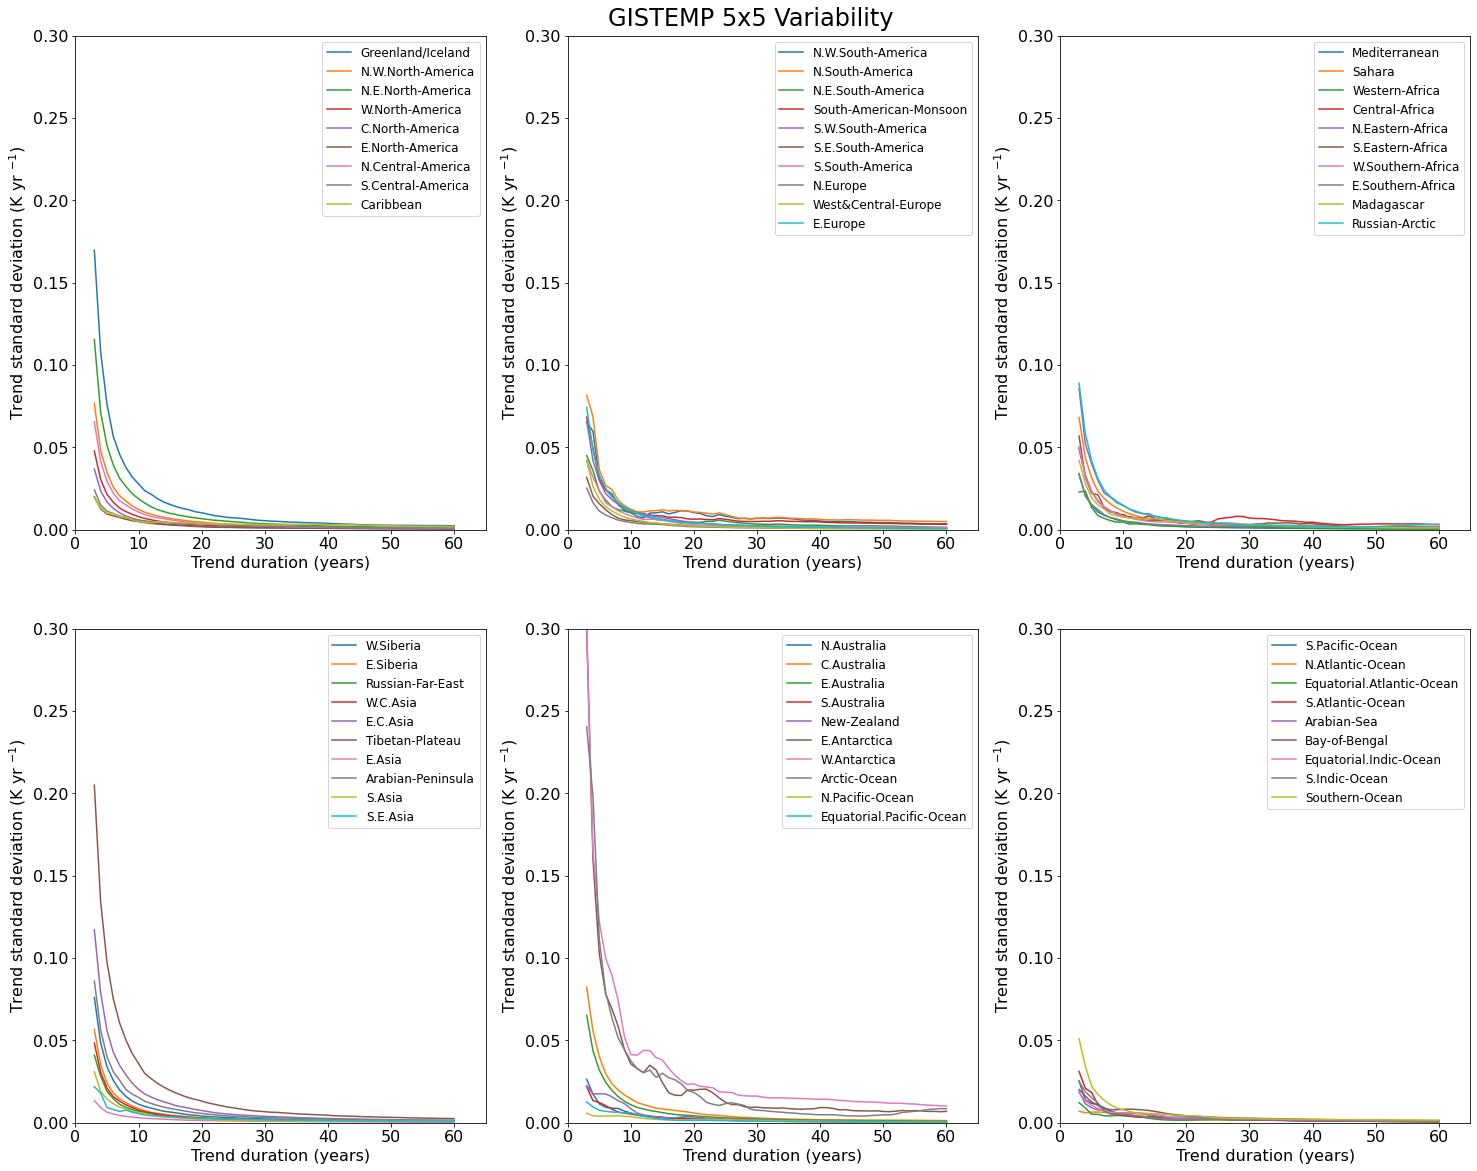

In [24]:
fig,axs = plt.subplots(2,3,figsize=(25,20))
axs = axs.flat

data = gistemp_5x5_trends_std

ax_i = 0
for i in data.RegionIndex:
    
    if (i+1) % 10 == 0: ax_i += 1 # Only put 10 regions per panel
    # if i > 9: ax_i += 1 # Only put 10 regions per panel
    
    _data = data.sel(RegionIndex=i)
    
    axs[ax_i].plot(_data.duration,_data,label=str(_data.RegionName.values))
    
    axs[ax_i].set_xlabel('Trend duration (years)',fontsize=16)
    axs[ax_i].set_ylabel('Trend standard deviation (K yr $^{-1}$)',fontsize=16)
    axs[ax_i].tick_params(labelsize=16)
    
    axs[ax_i].set_xlim(0,65)
    axs[ax_i].set_ylim(0,0.3)
    
    axs[ax_i].legend(fontsize=12)
    
fig.suptitle('GISTEMP 5x5 Variability',fontsize=24,x=0.5,y=0.90)

Text(0.5, 0.9, 'HadCRUT5 Variability')

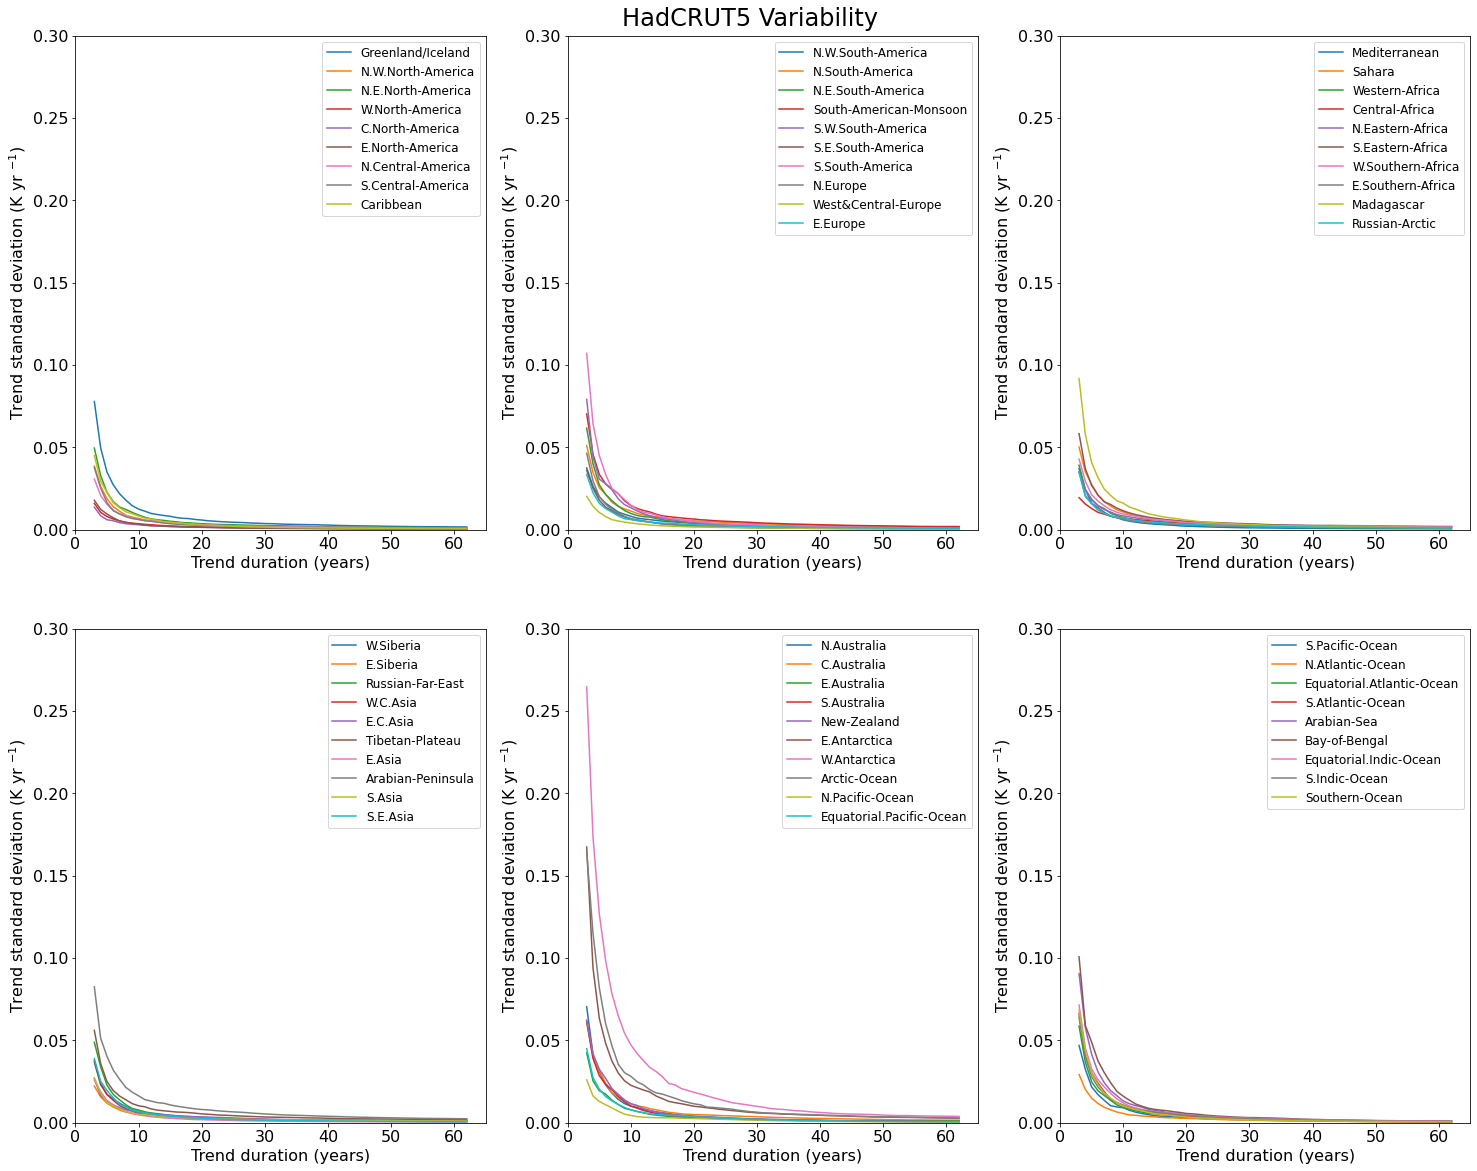

In [25]:
fig,axs = plt.subplots(2,3,figsize=(25,20))
axs = axs.flat

data = hadcrut5_trends_std

ax_i = 0
for i in data.RegionIndex:
    
    if (i+1) % 10 == 0: ax_i += 1 # Only put 10 regions per panel
    # if i > 9: ax_i += 1 # Only put 10 regions per panel
    
    _data = data.sel(RegionIndex=i)
    
    axs[ax_i].plot(_data.duration,_data,label=str(_data.RegionName.values))
    
    axs[ax_i].set_xlabel('Trend duration (years)',fontsize=16)
    axs[ax_i].set_ylabel('Trend standard deviation (K yr $^{-1}$)',fontsize=16)
    axs[ax_i].tick_params(labelsize=16)
    
    axs[ax_i].set_xlim(0,65)
    axs[ax_i].set_ylim(0,0.3)
    
    axs[ax_i].legend(fontsize=12)
    
fig.suptitle('HadCRUT5 Variability',fontsize=24,x=0.5,y=0.90)

There appear to be fairly large differences between the 2 observational products. Especially in the Americas.

### Plot ideas!

Create a spatial plot with the trend standard deviation at 5 or 10 years for each region so we can visualize it!

Normalize according to the Weatherhead math to evaluate the AR1 assumption.

#### Create a spatial plot with the trend standard deviation at 5 or 10 years for each region so we can visualize it!

In [26]:
import regionmask

import cartopy.crs as ccrs
import matplotlib.patheffects as pe

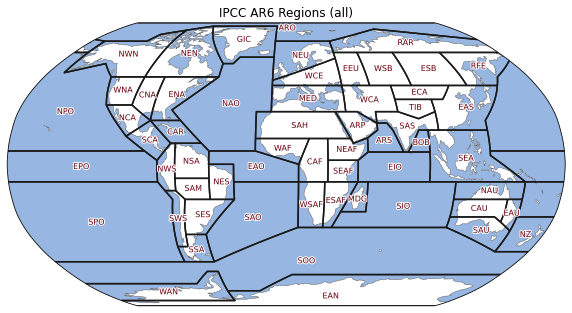

In [27]:
ipcc_ar6_regions_all   = regionmask.defined_regions.ar6.all

text_kws = dict(
    bbox=dict(color="none"),
    path_effects=[pe.withStroke(linewidth=2, foreground="w")],
    color="#67000d",
    fontsize=8,
)

_fig,_ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={'projection':ccrs.Robinson()})

_ax.set_title('IPCC AR6 Regions (all)')

ax = ipcc_ar6_regions_all.plot(ax = _ax,
    projection=ccrs.Robinson(), label="abbrev", add_ocean=True, resolution='110m', text_kws=text_kws
)
ax.set_global()


Generalized

In [28]:
ipcc_ar6_regions_land   = regionmask.defined_regions.ar6.land
ipcc_ar6_regions_all    = regionmask.defined_regions.ar6.all

# unc_mask = ipcc_ar6_regions_land.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)
unc_mask = ipcc_ar6_regions_all.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)

# Model masks
cesm1_unc_mask   = unc_mask.copy()
mpi_unc_mask     = unc_mask.copy()
canesm2_unc_mask = unc_mask.copy()
esm2m_unc_mask   = unc_mask.copy()

# Obs masks
gistemp_2x2_unc_mask  = unc_mask.copy()
gistemp_5x5_unc_mask  = unc_mask.copy()
hadcrut5_unc_mask     = unc_mask.copy()

del unc_mask

for i in ipcc_ar6_regions_all.numbers:
        
    # Replace the mask value with the 10-year trend standard deviation.
    cesm1_unc_mask   = xr.where(cesm1_unc_mask==i,cesm1_pic_trends_std.sel(RegionIndex=i,duration=10),cesm1_unc_mask)
    mpi_unc_mask     = xr.where(mpi_unc_mask==i,mpi_pic_trends_std.sel(RegionIndex=i,duration=10),mpi_unc_mask)
    canesm2_unc_mask = xr.where(canesm2_unc_mask==i,canesm2_pic_trends_std.sel(RegionIndex=i,duration=10),canesm2_unc_mask)
    esm2m_unc_mask   = xr.where(esm2m_unc_mask==i,esm2m_pic_trends_std.sel(RegionIndex=i,duration=10),esm2m_unc_mask)
    
    gistemp_2x2_unc_mask = xr.where(gistemp_2x2_unc_mask==i,gistemp_2x2_trends_std.sel(RegionIndex=i,duration=10),gistemp_2x2_unc_mask)
    gistemp_5x5_unc_mask = xr.where(gistemp_5x5_unc_mask==i,gistemp_5x5_trends_std.sel(RegionIndex=i,duration=10),gistemp_5x5_unc_mask)
    hadcrut5_unc_mask    = xr.where(hadcrut5_unc_mask==i,hadcrut5_trends_std.sel(RegionIndex=i,duration=10),hadcrut5_unc_mask)
    

In [29]:
from functions import sp_map

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


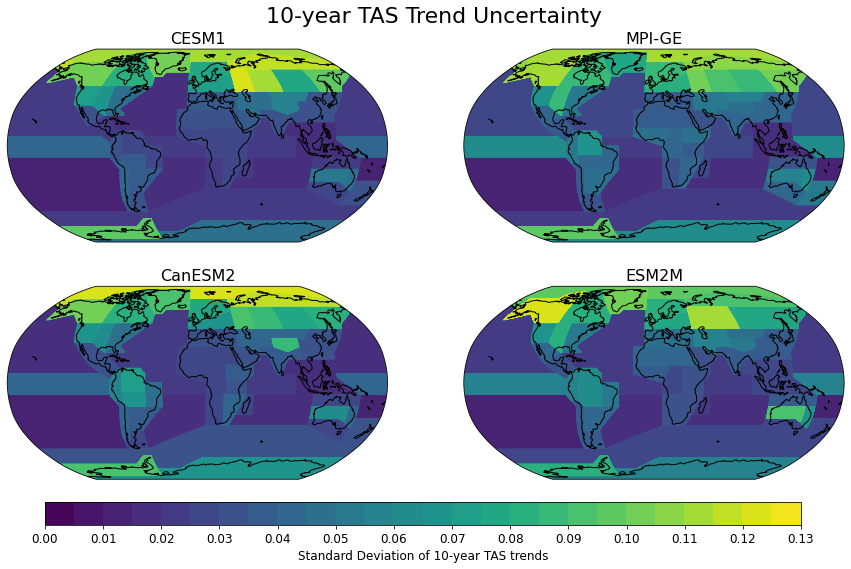

In [30]:
fig,axs = sp_map(2,2,projection=ccrs.Robinson(),figsize=(15,8))
axs = axs.flat

cax = plt.axes([0.16, 0.05, 0.7, 0.04])

masks = [cesm1_unc_mask,mpi_unc_mask,canesm2_unc_mask,esm2m_unc_mask]
models = ['CESM1','MPI-GE','CanESM2','ESM2M']

for _ax,_mask,_label in zip(axs,masks,models):
    
    im = _ax.contourf(_mask.lon,_mask.lat,_mask, 60,
                      transform=ccrs.PlateCarree(),levels=np.linspace(0,0.13,27))

    _ax.coastlines()
    _ax.set_global()
    _ax.set_title(_label,fontsize=16)

cbar = fig.colorbar(im,orientation='horizontal',
                    ticks=np.linspace(0,0.13,14),
                    cax=cax,
                   )

cbar.ax.tick_params(labelsize=12) 
cbar.set_label('Standard Deviation of 10-year TAS trends',fontsize=12)

fig.suptitle('10-year TAS Trend Uncertainty',fontsize=22,x=0.52,y=0.95)

plt.show()

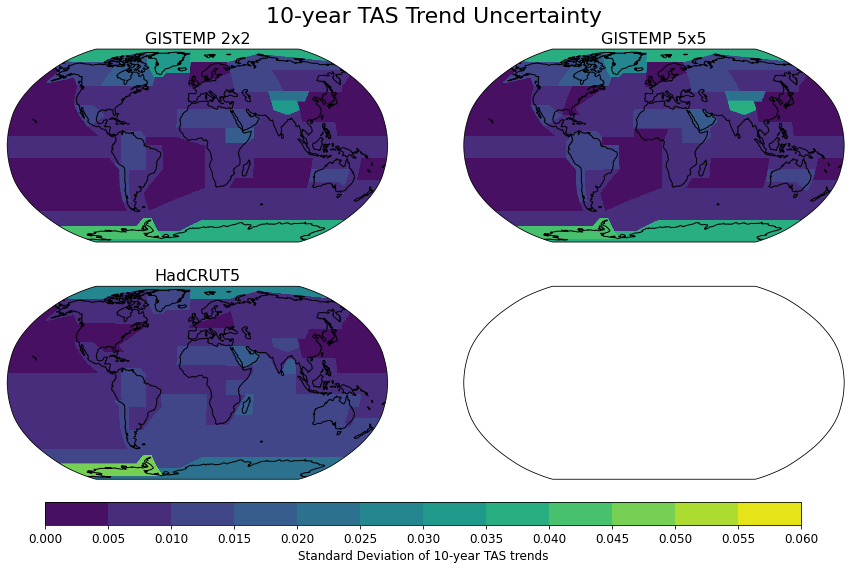

In [31]:
fig,axs = sp_map(2,2,projection=ccrs.Robinson(),figsize=(15,8))
axs = axs.flat

cax = plt.axes([0.16, 0.05, 0.7, 0.04])

# masks = [cesm1_unc_mask,mpi_unc_mask,canesm2_unc_mask,esm2m_unc_mask]
# models = ['CESM1','MPI-GE','CanESM2','ESM2M']

masks = [gistemp_2x2_unc_mask,gistemp_5x5_unc_mask,hadcrut5_unc_mask]
models = ['GISTEMP 2x2','GISTEMP 5x5','HadCRUT5',]

for _ax,_mask,_label in zip(axs,masks,models):
    
    im = _ax.contourf(_mask.lon,_mask.lat,_mask, 60,
                      transform=ccrs.PlateCarree(),levels=np.linspace(0,0.06,13)) # levels=np.linspace(0,0.13,27))

    _ax.coastlines()
    _ax.set_global()
    _ax.set_title(_label,fontsize=16)

cbar = fig.colorbar(im,orientation='horizontal',
                    ticks=np.linspace(0,0.06,13),
                    # ticks=np.linspace(0,0.13,14),
                    cax=cax,
                   )

cbar.ax.tick_params(labelsize=12) 
cbar.set_label('Standard Deviation of 10-year TAS trends',fontsize=12)

fig.suptitle('10-year TAS Trend Uncertainty',fontsize=22,x=0.52,y=0.95)

plt.show()

The plot with the observational uncertainty has less meaning, because the temporal change in trend uncertainty is not as consistent as with the models. (i.e. 10-year uncertainty isn’t a good proxy for the rest of the observational record). In general, the observational uncertainty resembles the internal variability, but is about half the magnitude.

## Compute time-to-emergence and observational delay

Calculate a 95% confidence interval on the PI-Control trends.

In [32]:
# CESM1
cesm1_pic_trends_2_5perc  = percentile_vec(cesm1_pic_trends_all,q=2.5,core_dim='startyear').compute()
cesm1_pic_trends_97_5perc = percentile_vec(cesm1_pic_trends_all,q=97.5,core_dim='startyear').compute()

# MPI-GE
mpi_pic_trends_2_5perc  = percentile_vec(mpi_pic_trends_all,q=2.5,core_dim='startyear').compute()
mpi_pic_trends_97_5perc = percentile_vec(mpi_pic_trends_all,q=97.5,core_dim='startyear').compute()

# CanESM2
canesm2_pic_trends_2_5perc  = percentile_vec(canesm2_pic_trends_all,q=2.5,core_dim='startyear').compute()
canesm2_pic_trends_97_5perc = percentile_vec(canesm2_pic_trends_all,q=97.5,core_dim='startyear').compute()

# ESM2M
esm2m_pic_trends_2_5perc  = percentile_vec(esm2m_pic_trends_all,q=2.5,core_dim='startyear').compute()
esm2m_pic_trends_97_5perc = percentile_vec(esm2m_pic_trends_all,q=97.5,core_dim='startyear').compute()

Observational Uncertainty

In [33]:
gistemp_2x2_trends_all  = xr.open_dataarray(*gistemp_2x2_trends_filepath)

gistemp_5x5_trends_all  = xr.open_dataarray(*gistemp_5x5_trends_filepath)

hadcrut5_trends_all     = xr.open_dataarray(*hadcrut5_trends_filepath)

In [34]:
gistemp_2x2_trends_1960 = gistemp_2x2_trends_all.sel(startyear=1960)
gistemp_5x5_trends_1960 = gistemp_5x5_trends_all.sel(startyear=1960)
hadcrut5_trends_1960    = hadcrut5_trends_all.sel(startyear=1960)

In [35]:
# Compute the low and high bounds on the trends from the observational products

# GISTEMP 2x2
gistemp_2x2_trends_2_5perc  = percentile_vec(gistemp_2x2_trends_1960,q=2.5,core_dim='record')
gistemp_2x2_trends_50perc  = percentile_vec(gistemp_2x2_trends_1960,q=50,core_dim='record')
gistemp_2x2_trends_97_5perc = percentile_vec(gistemp_2x2_trends_1960,q=97.5,core_dim='record')

# GISTEMP 5x5
gistemp_5x5_trends_2_5perc  = percentile_vec(gistemp_5x5_trends_1960,q=2.5,core_dim='record')
gistemp_5x5_trends_50perc  = percentile_vec(gistemp_5x5_trends_1960,q=50,core_dim='record')
gistemp_5x5_trends_97_5perc = percentile_vec(gistemp_5x5_trends_1960,q=97.5,core_dim='record')

# HadCRUT5
hadcrut5_trends_2_5perc  = percentile_vec(hadcrut5_trends_1960,q=2.5,core_dim='realization')
hadcrut5_trends_50perc  = percentile_vec(hadcrut5_trends_1960,q=50,core_dim='realization')
hadcrut5_trends_97_5perc = percentile_vec(hadcrut5_trends_1960,q=97.5,core_dim='realization')

__Simple plot for a Sanity Check__

In [51]:
from functions import to_png

In [ ]:
# to_png(file=fig,filename='fig_OLRemergence',dpi=300,ext='pdf',bbox_inches='tight')

In [53]:
gistemp_2x2_trends_2_5perc.RegionIndex

<xarray.DataArray 'RegionIndex' (RegionIndex: 58)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57])
Coordinates:
  * RegionIndex   (RegionIndex) int64 0 1 2 3 4 5 6 7 ... 51 52 53 54 55 56 57
    startyear     int64 1960
    RegionName    (RegionIndex) object dask.array<chunksize=(58,), meta=np.ndarray>
    RegionAbbrev  (RegionIndex) object dask.array<chunksize=(58,), meta=np.ndarray>

/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


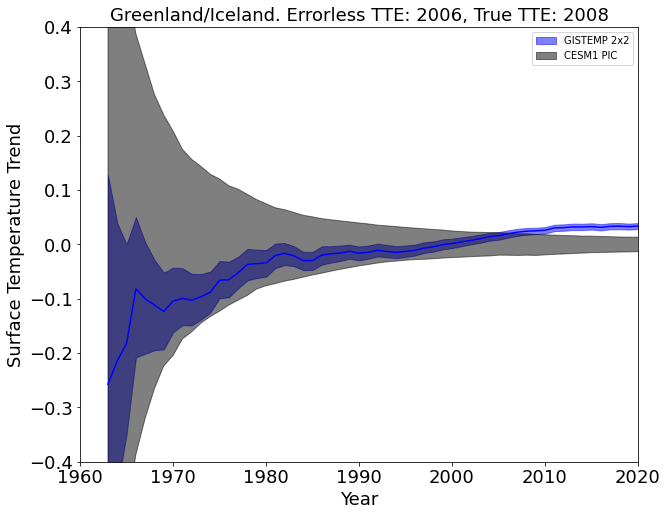

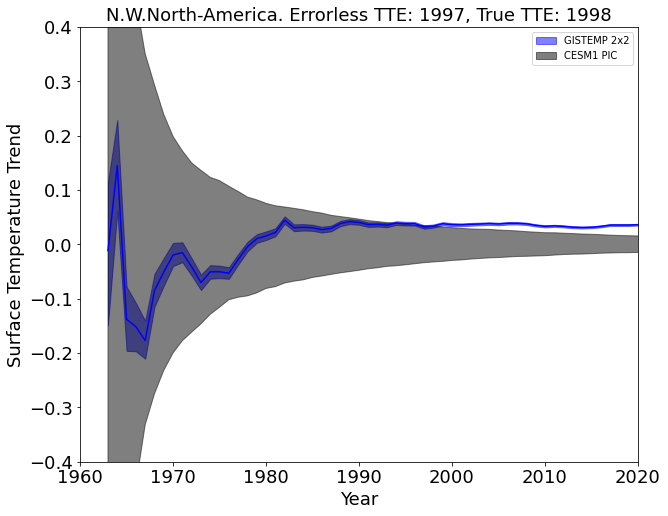

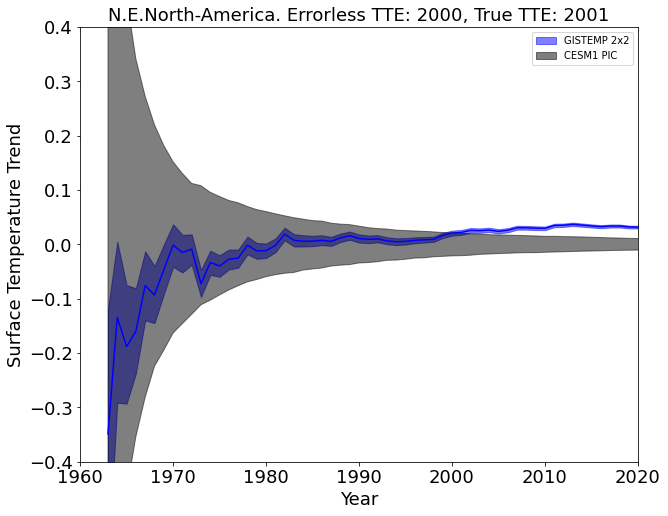

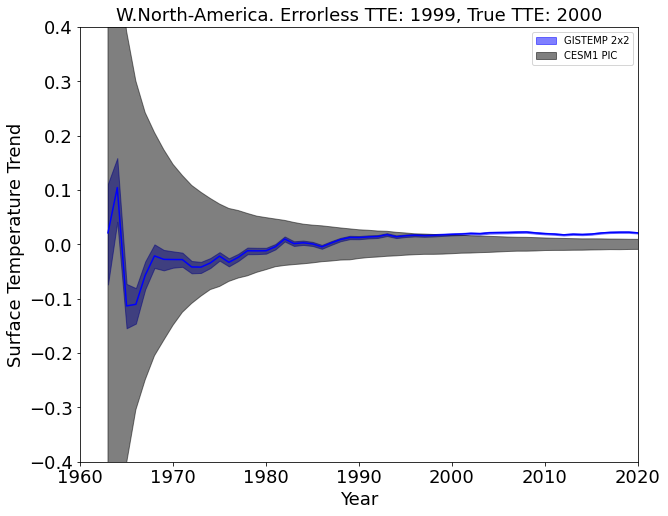

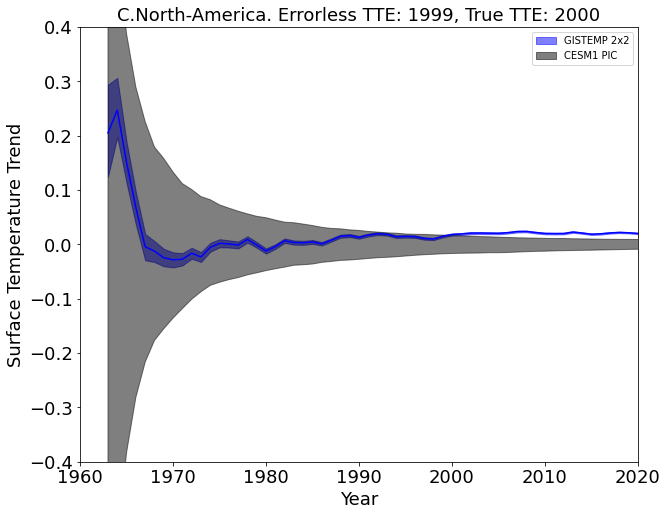

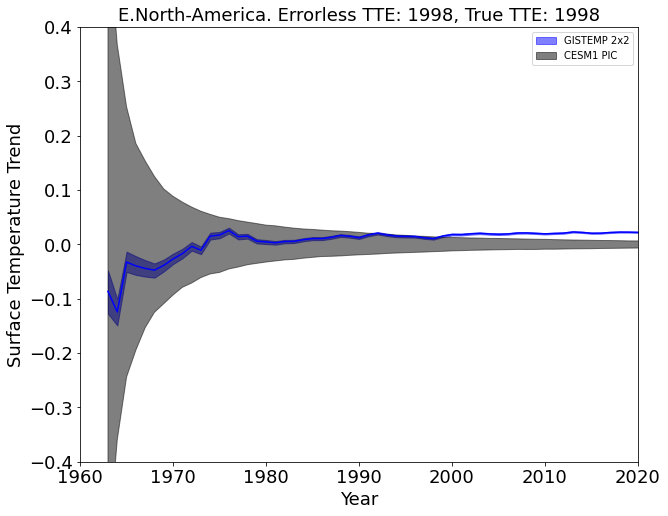

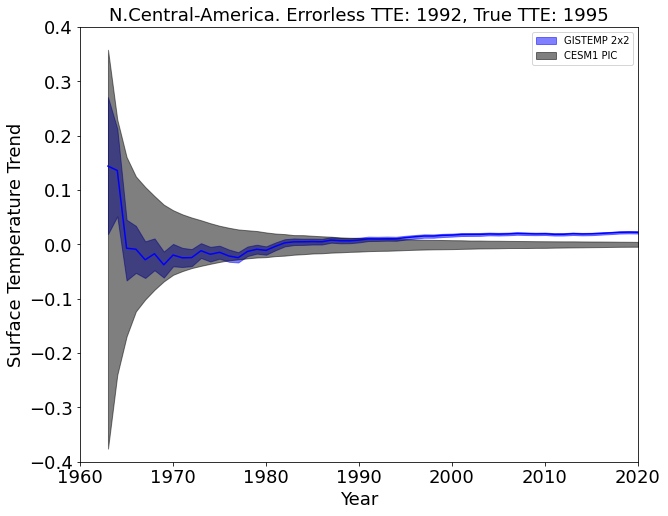

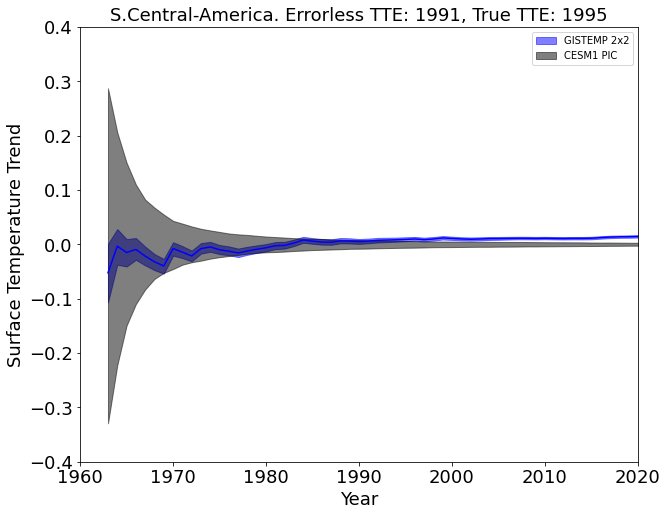

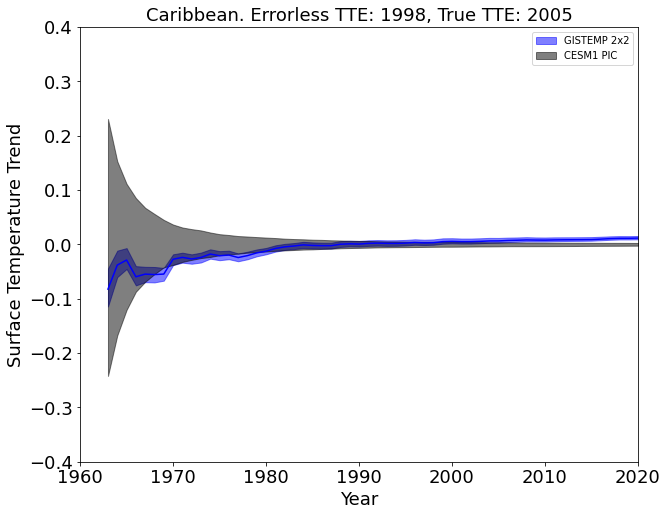

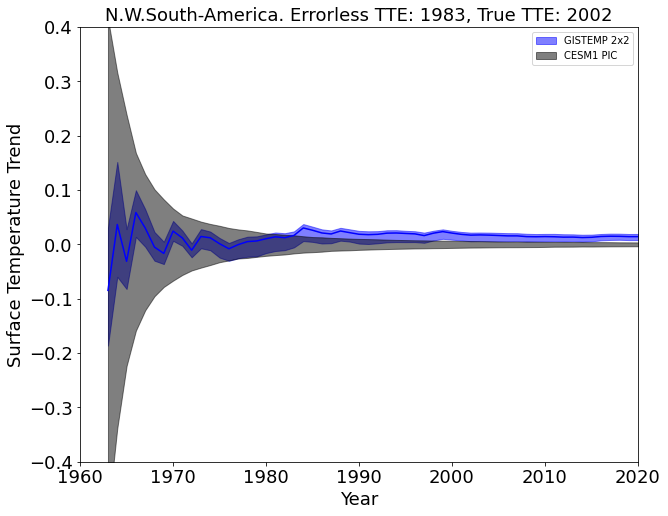

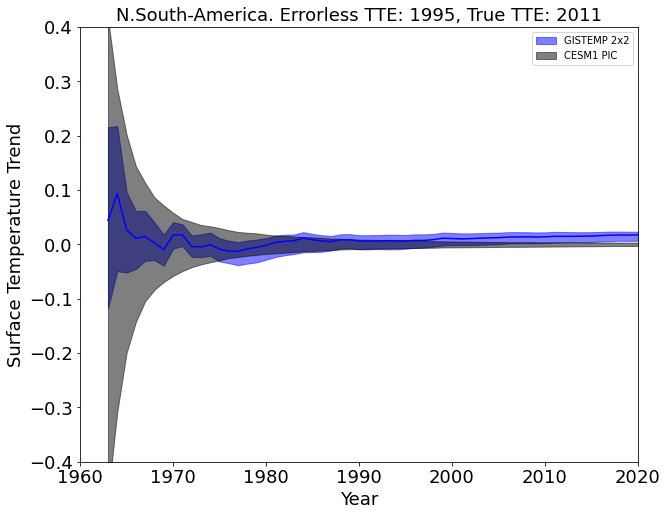

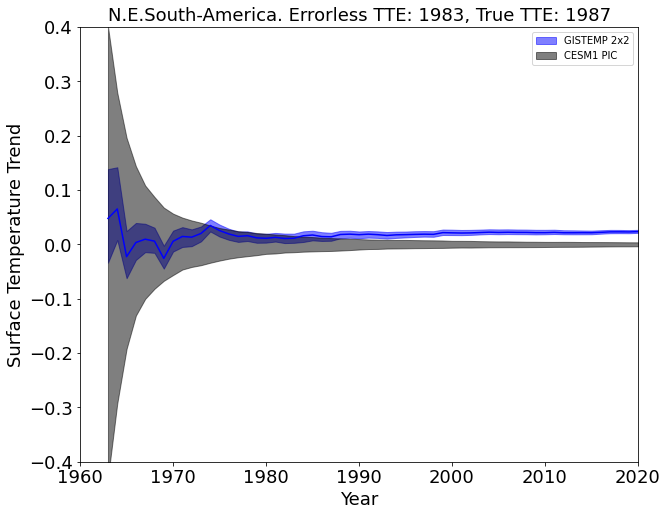

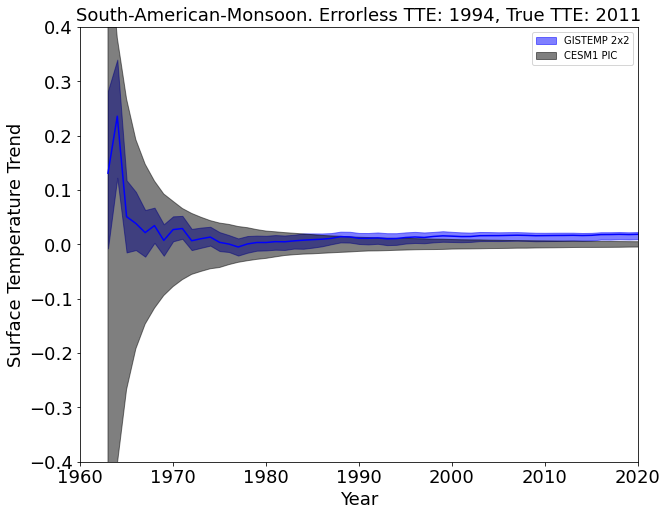

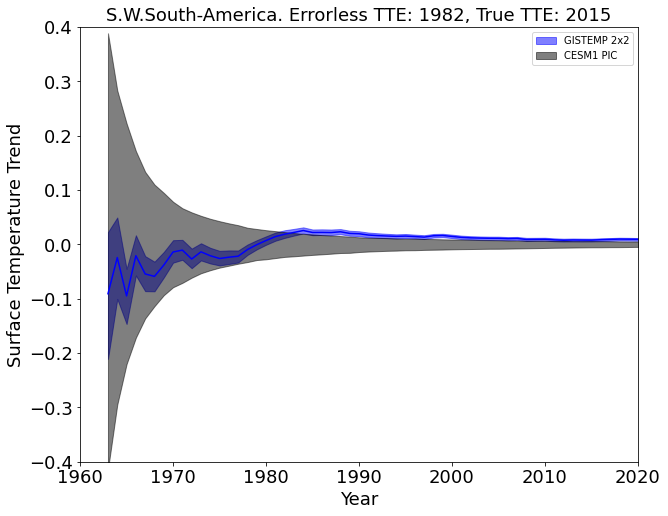

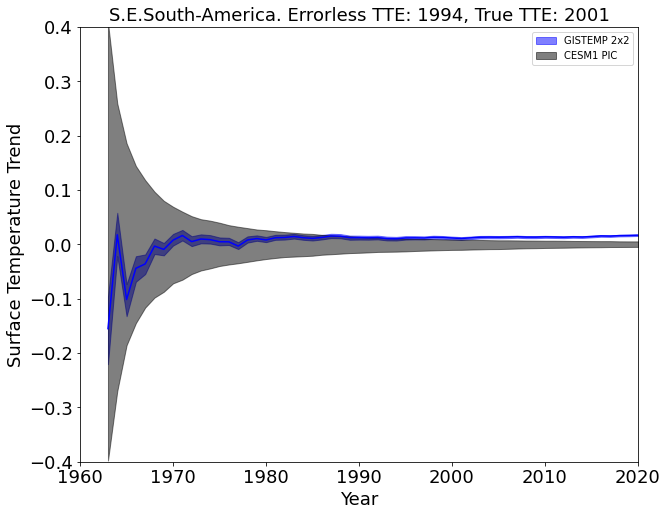

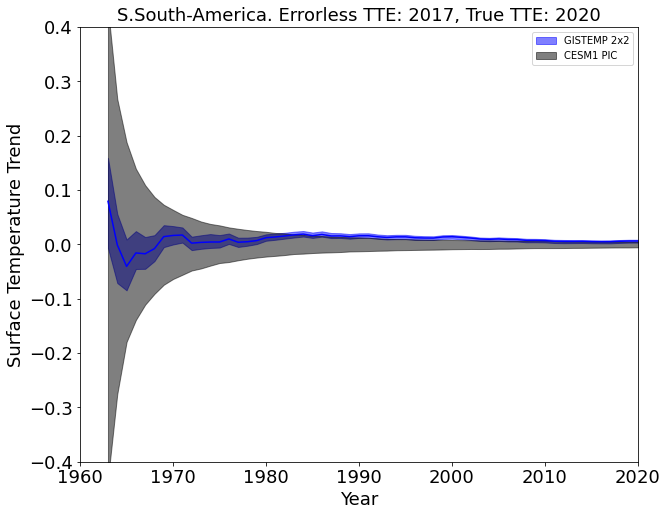

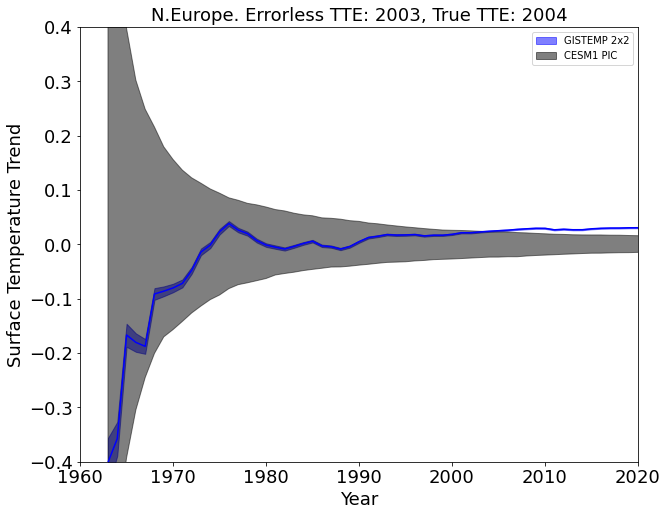

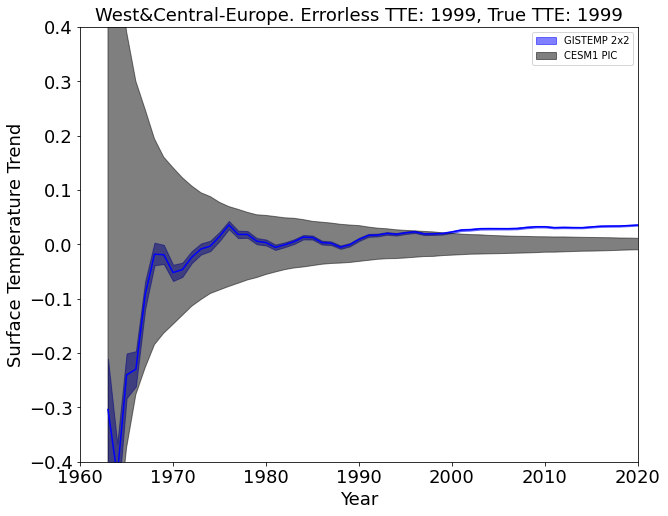

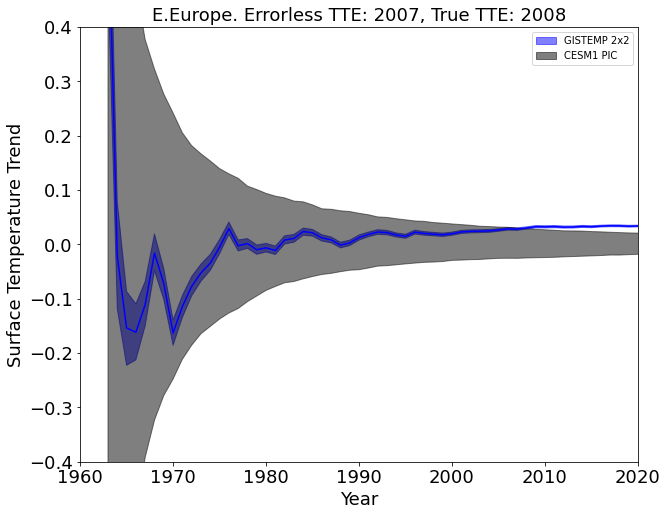

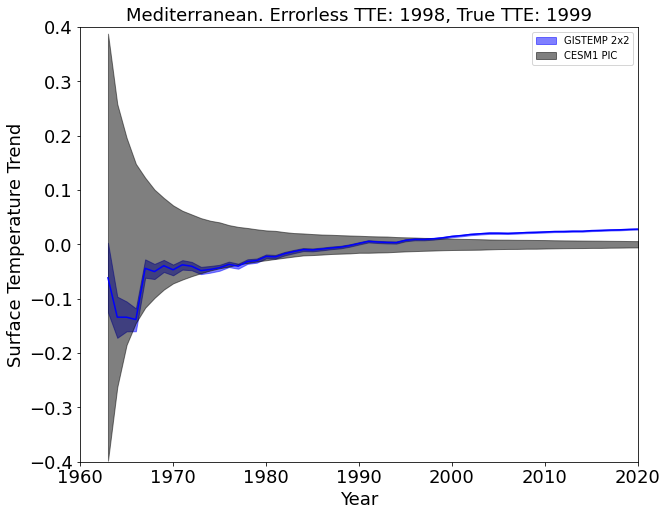

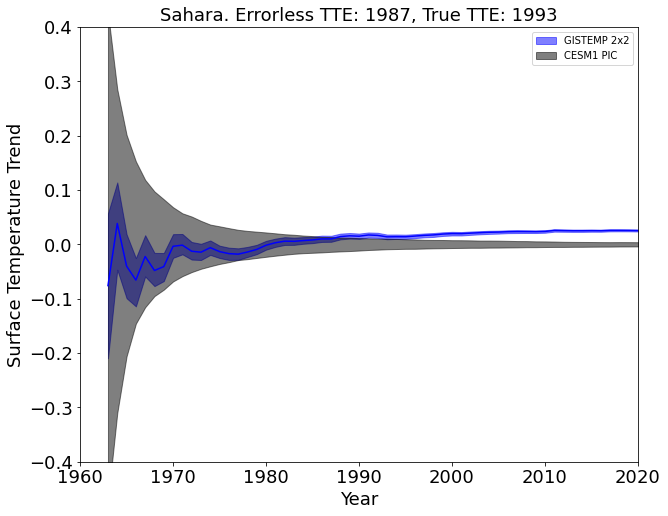

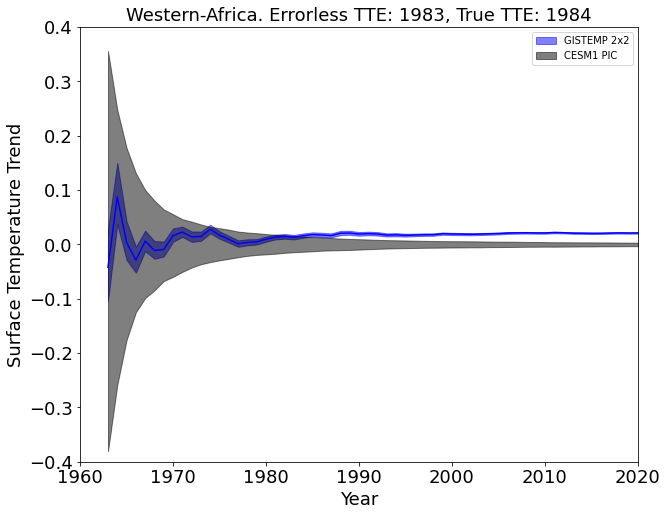

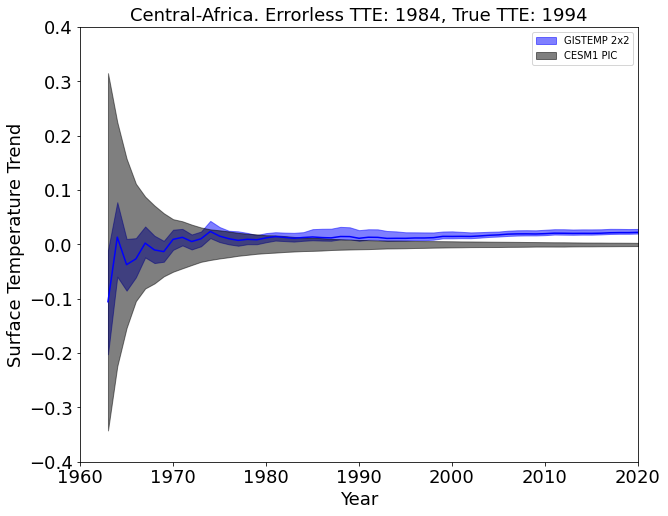

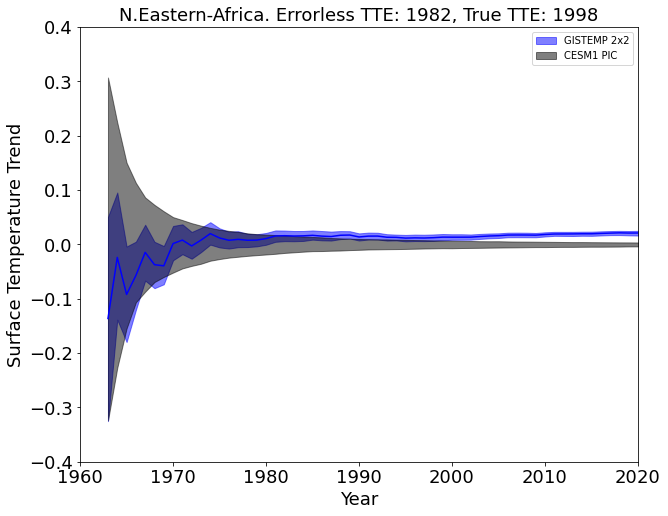

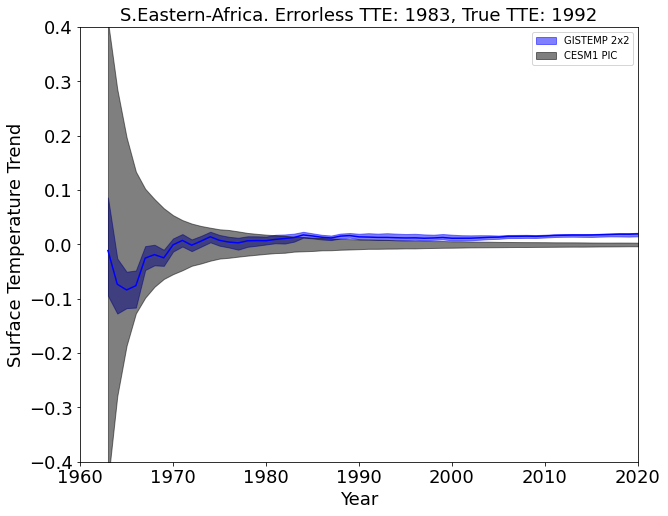

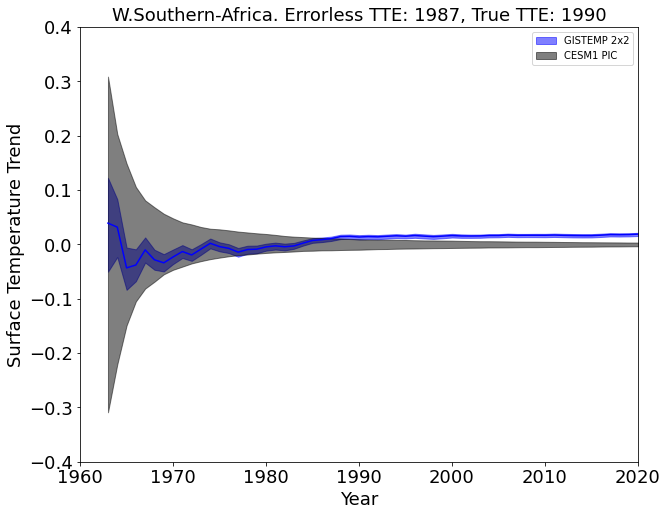

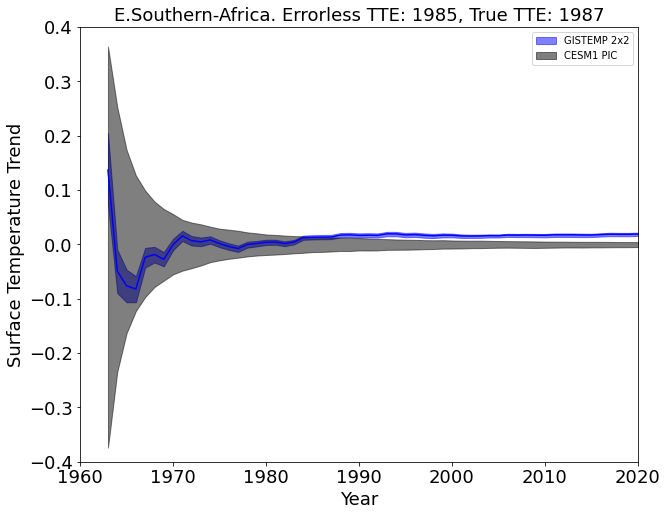

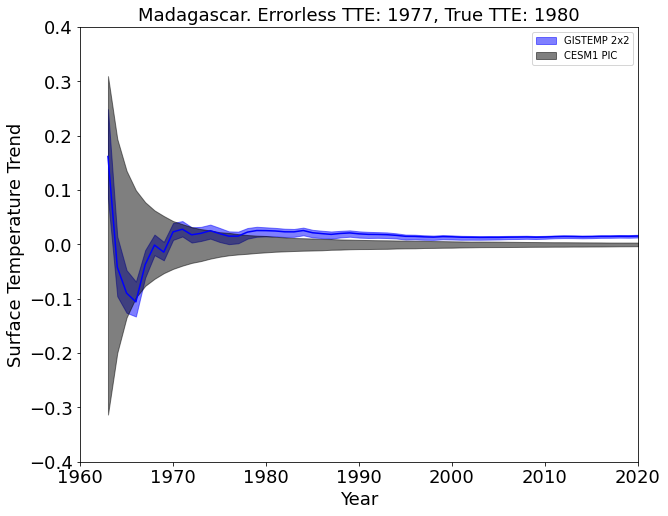

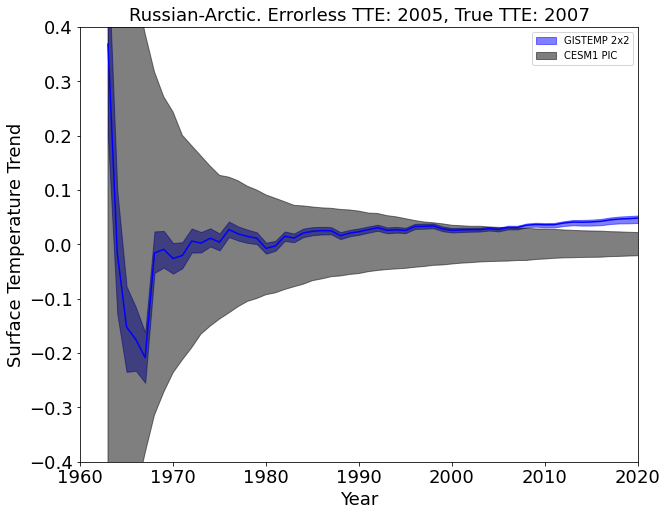

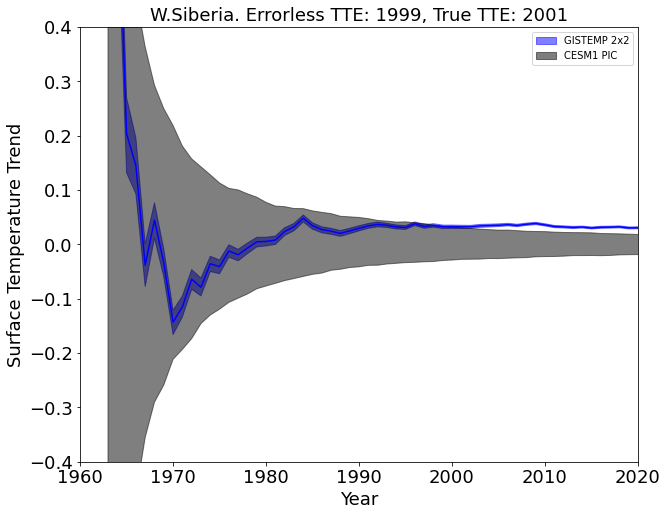

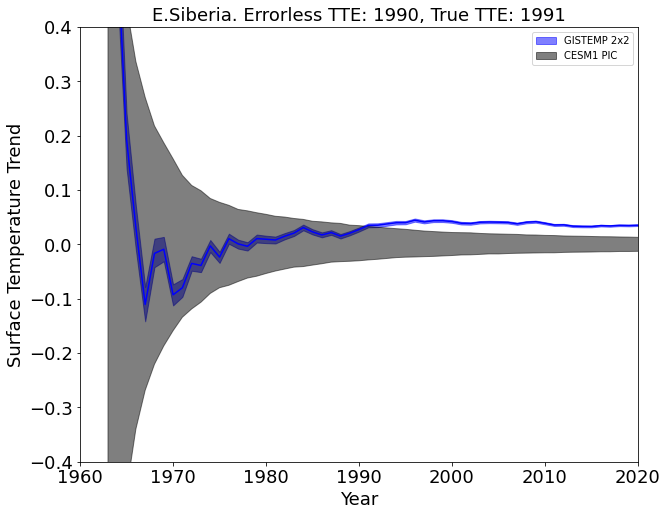

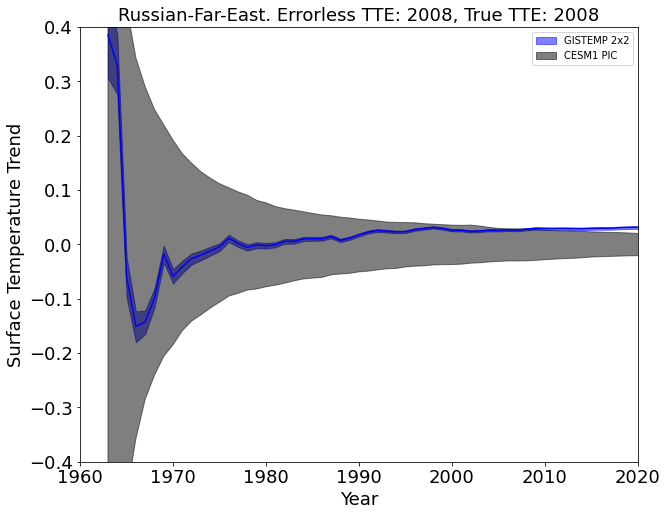

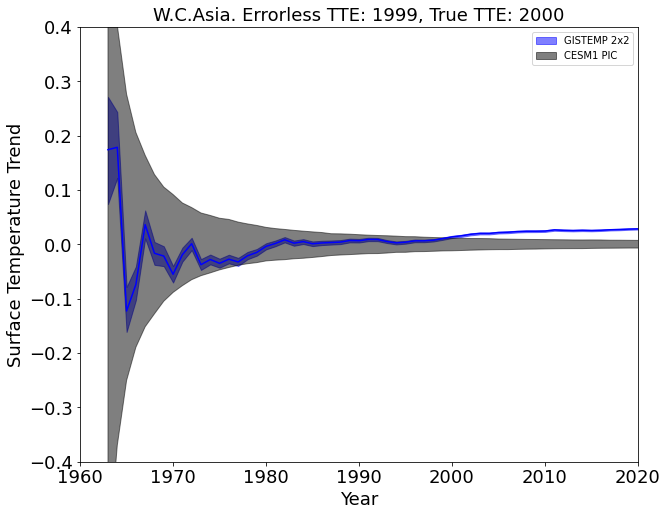

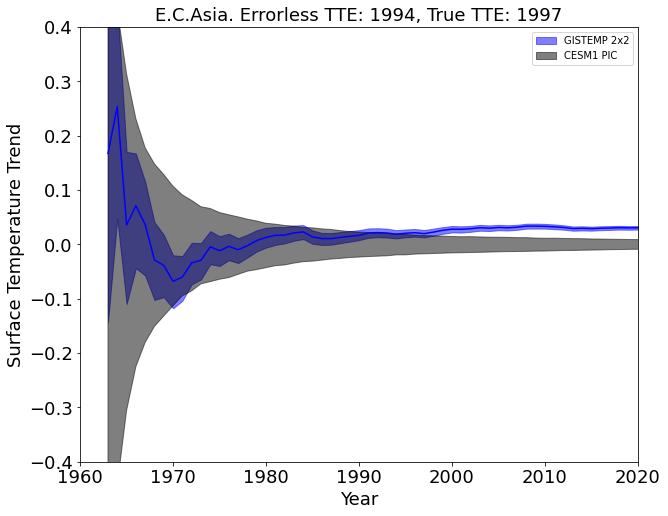

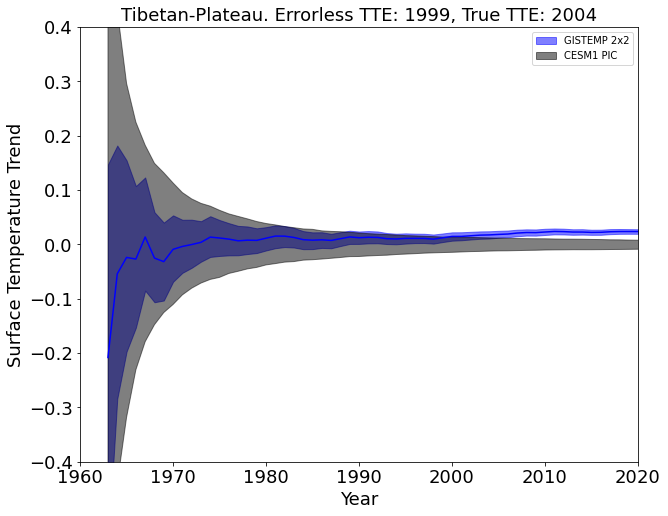

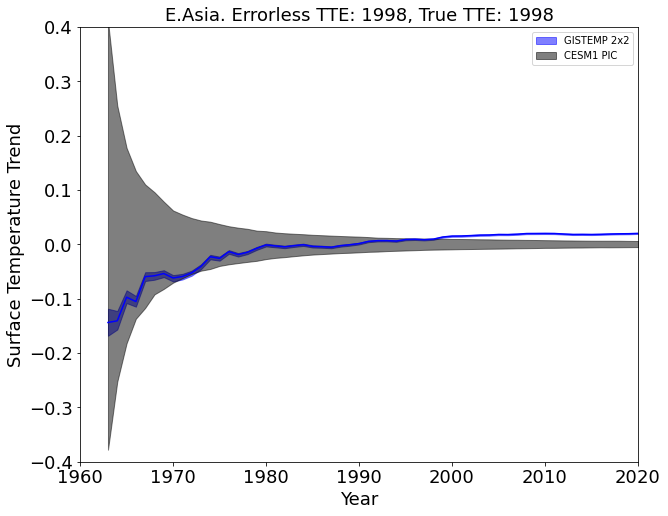

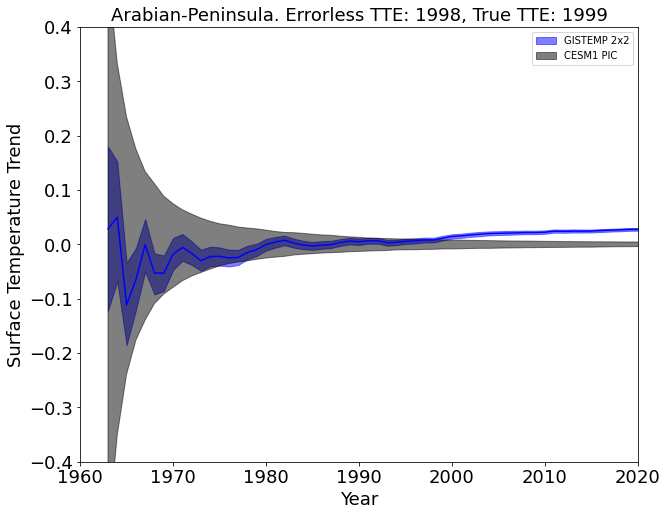

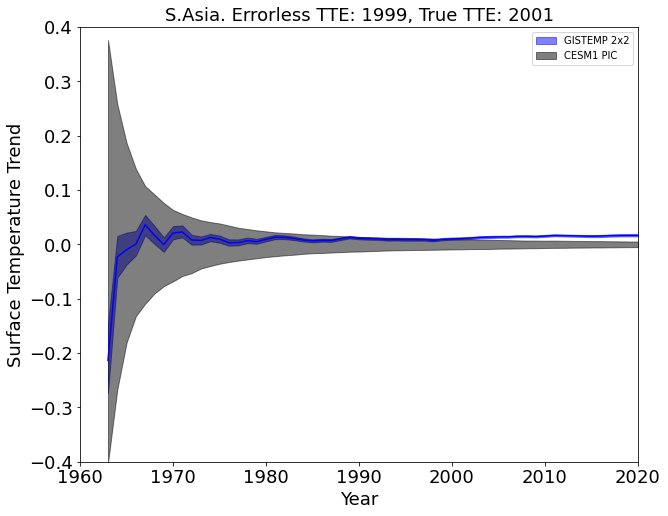

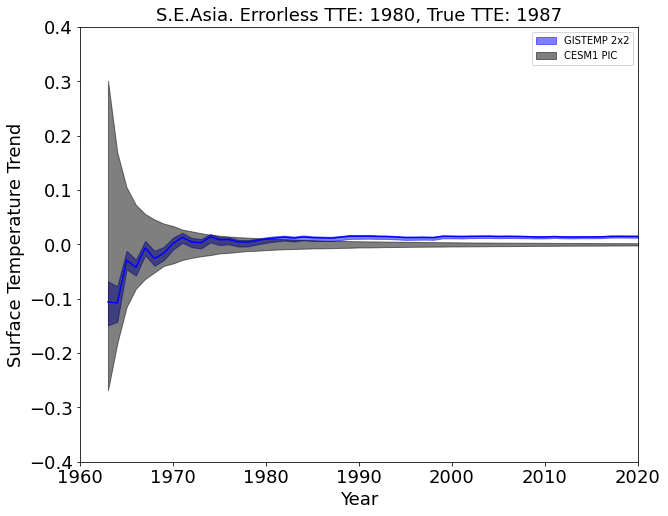

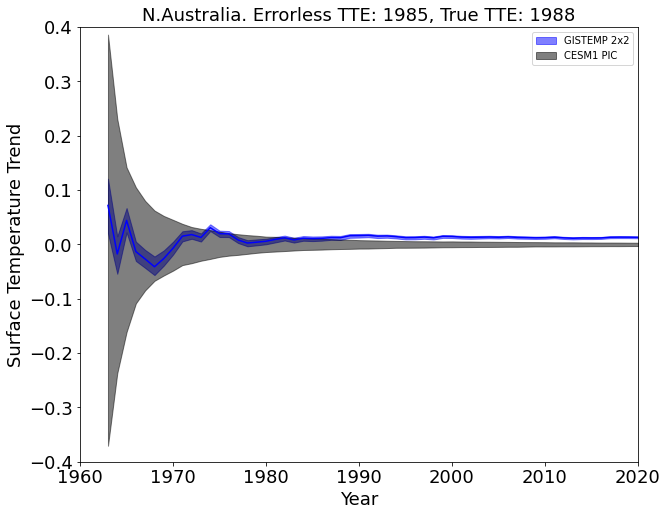

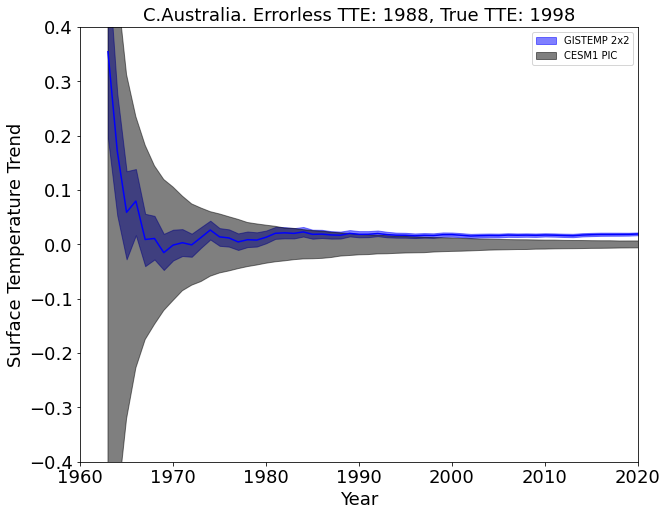

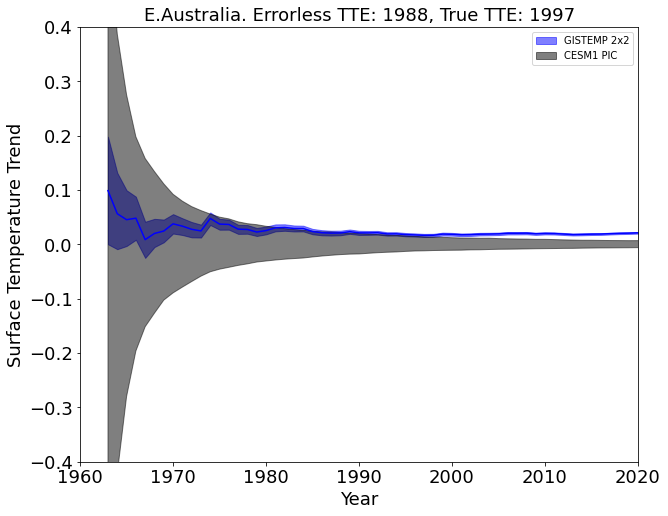

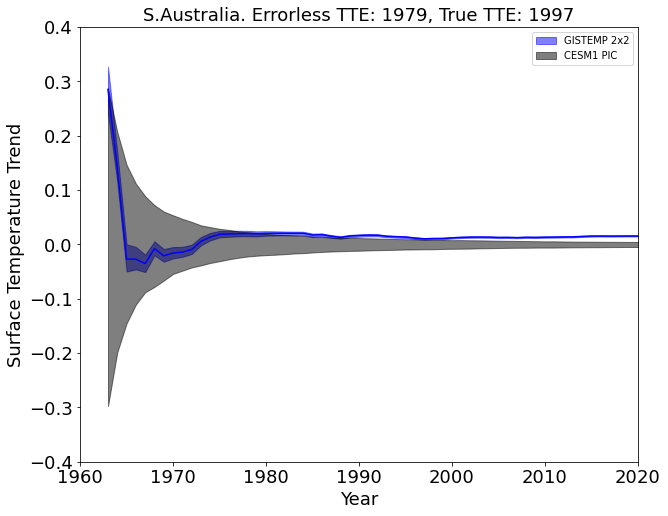

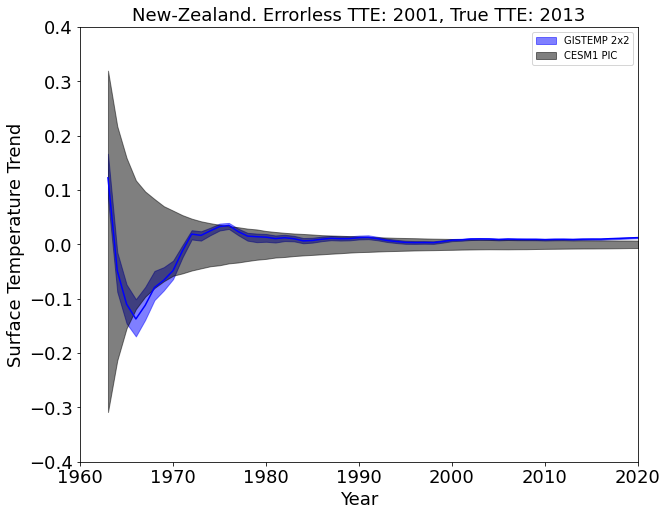

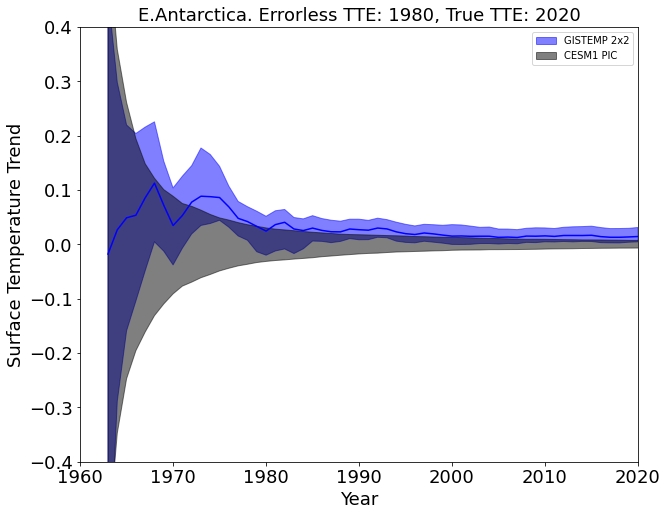

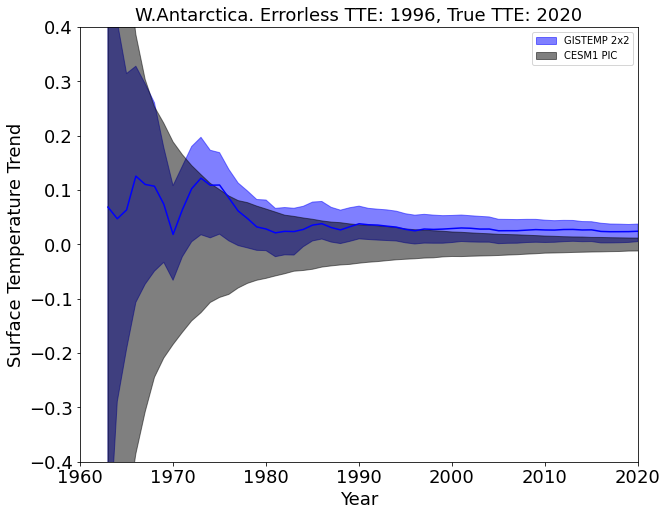

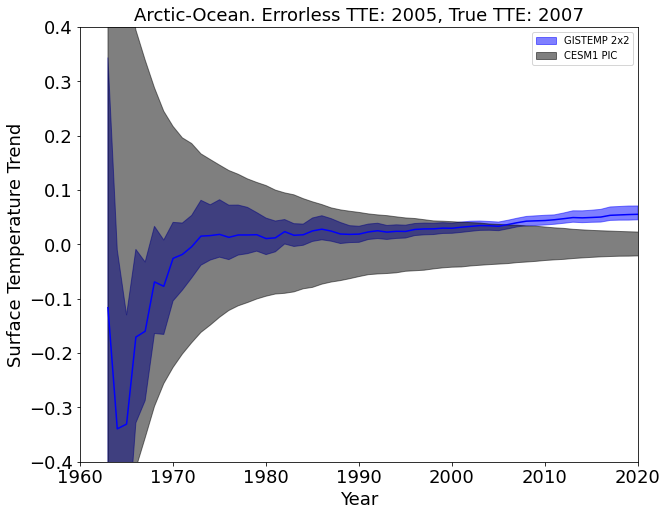

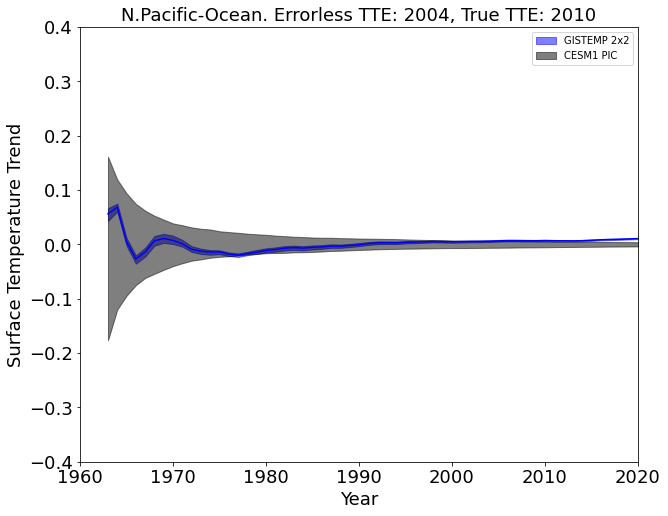

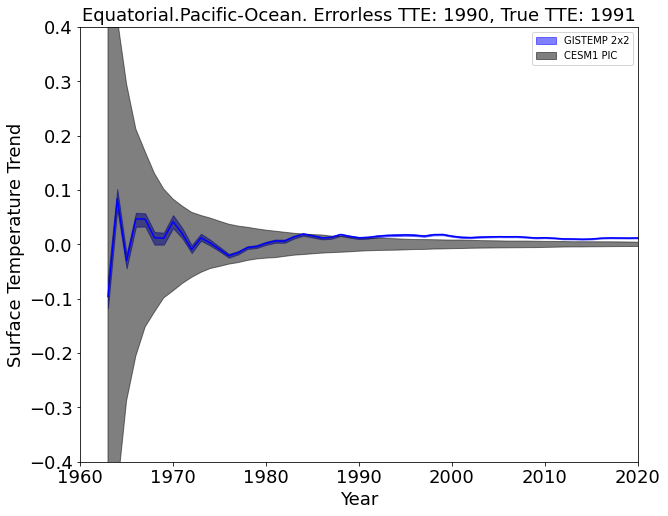

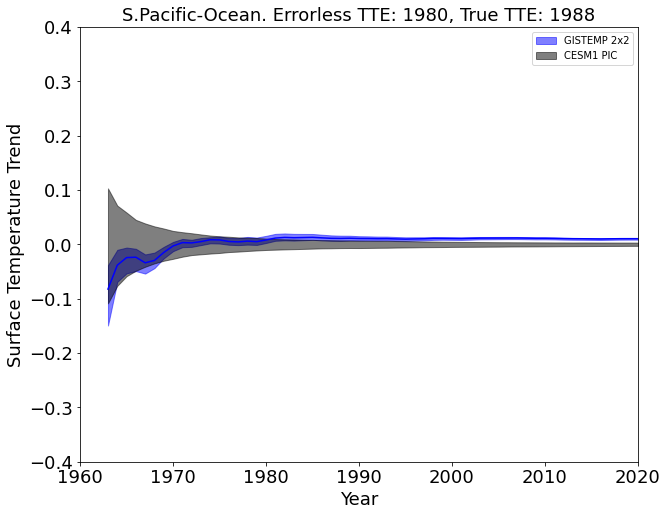

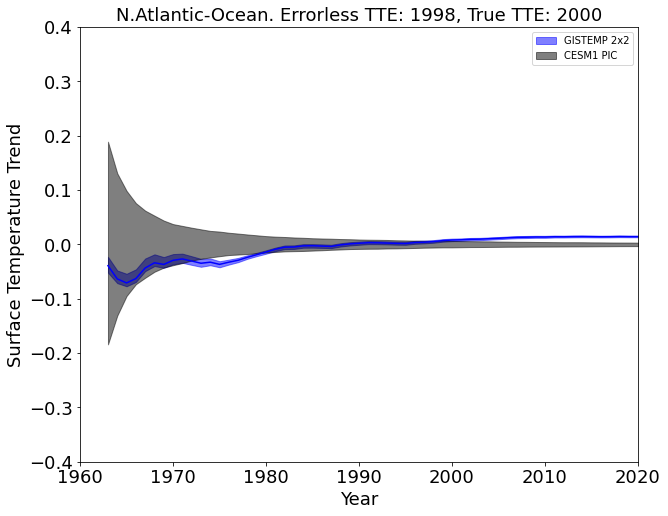

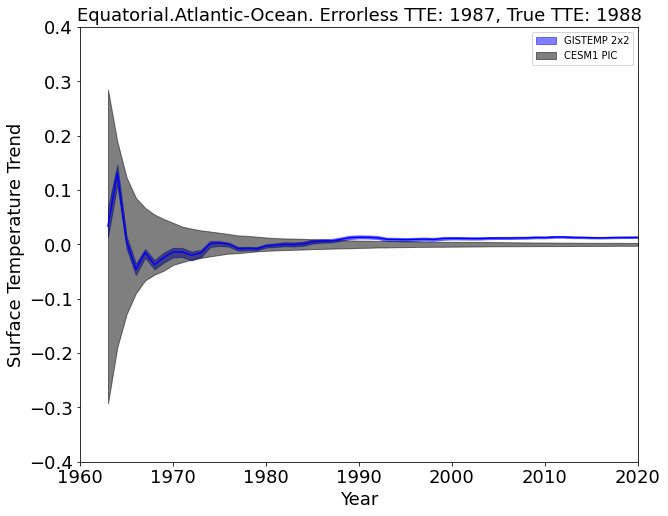

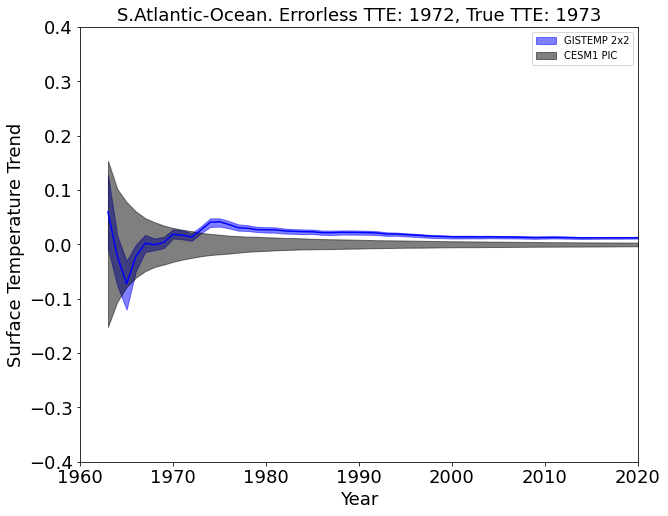

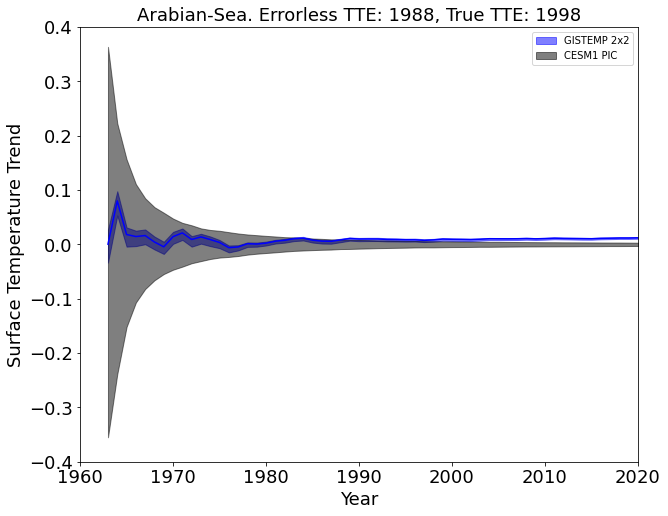

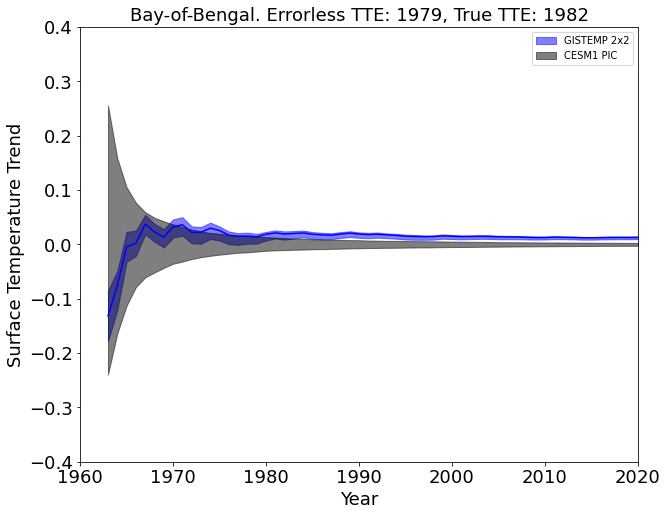

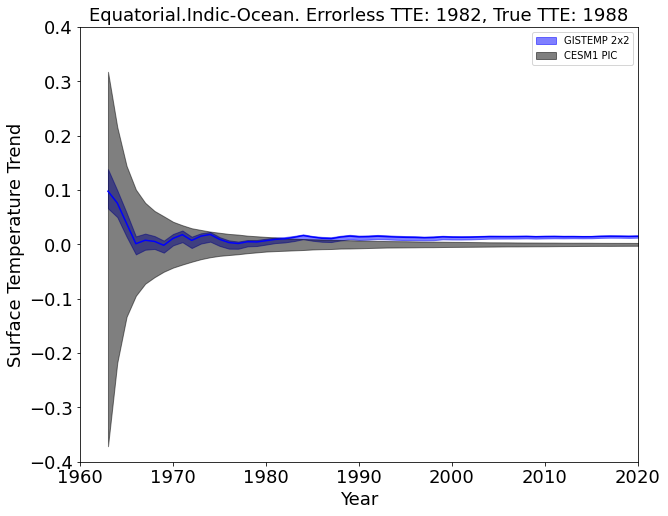

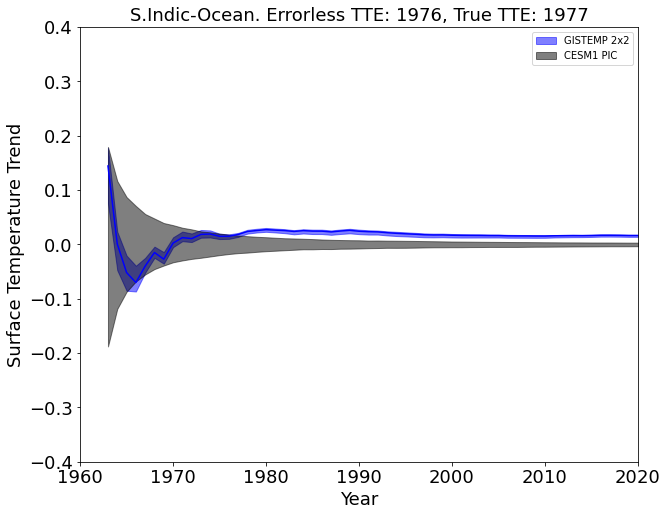

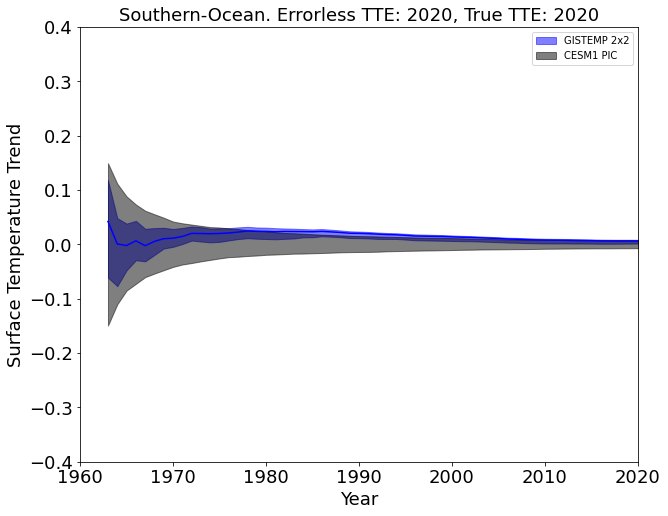

In [59]:
for region_index,region_name in zip(gistemp_2x2_trends_2_5perc.RegionIndex,
                                    gistemp_2x2_trends_2_5perc.RegionName):

# region_index = 49#46 9

    fig,ax = plt.subplots(1,1,figsize=(10,8))

    year_gistemp = 1960 + gistemp_2x2_trends_2_5perc.duration
    year_cesm1   = 1960 + cesm1_pic_trends_2_5perc.duration

    mean_tte_bool = gistemp_2x2_trends_50perc.sel(RegionIndex=region_index) > cesm1_pic_trends_97_5perc.sel(RegionIndex=region_index)
    mean_tte      = 1960 + mean_tte_bool.duration.where(~mean_tte_bool).max(dim='duration')

    true_tte_bool = gistemp_2x2_trends_2_5perc.sel(RegionIndex=region_index) > cesm1_pic_trends_97_5perc.sel(RegionIndex=region_index)
    true_tte      = 1960 + true_tte_bool.duration.where(~true_tte_bool).max(dim='duration')

    plt.fill_between(year_gistemp, #gistemp_2x2_trends_2_5perc.duration,
                     gistemp_2x2_trends_2_5perc.sel(RegionIndex=region_index),
                     gistemp_2x2_trends_97_5perc.sel(RegionIndex=region_index),
                     color='blue',
                     alpha=0.5,
                     label='GISTEMP 2x2',
                    )

    plt.fill_between(year_cesm1, #cesm1_pic_trends_2_5perc.duration,
                     cesm1_pic_trends_2_5perc.sel(RegionIndex=region_index),
                     cesm1_pic_trends_97_5perc.sel(RegionIndex=region_index),
                     color='black',
                     alpha=0.5,
                     label='CESM1 PIC',
                    )

    plt.plot(year_gistemp, #gistemp_2x2_trends_2_5perc.duration,
             gistemp_2x2_trends_50perc.sel(RegionIndex=region_index),
             color='blue'
            )

    ax.tick_params(axis='both', labelsize=18)

    ax.set_ylabel('Surface Temperature Trend',fontsize=18)
    ax.set_xlabel('Year',fontsize=18)

    ax.set_xlim(1960,2020)
    ax.set_ylim(-0.4,0.4)

    title_p1 = str(gistemp_2x2_trends_2_5perc.sel(RegionIndex=region_index).RegionName.values)
    title_p2 = 'Errorless TTE: %d, True TTE: %d' % (mean_tte,true_tte)

    ax.set_title('%s. %s' % (title_p1,title_p2),fontsize=18)

    plt.legend()

    to_png(file=fig,filename='coneplot_Region%d_%s' % (region_index,str(region_name.values).replace('/','_')),
           dpi=300,
           ext='pdf',
           bbox_inches='tight')
    
    # break

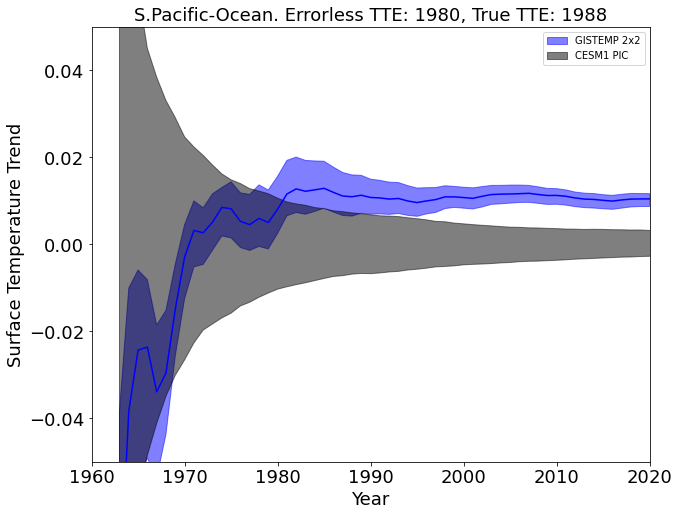

In [50]:
region_index = 49#46 9

fig,ax = plt.subplots(1,1,figsize=(10,8))

year_gistemp = 1960 + gistemp_2x2_trends_2_5perc.duration
year_cesm1   = 1960 + cesm1_pic_trends_2_5perc.duration

mean_tte_bool = gistemp_2x2_trends_50perc.sel(RegionIndex=region_index) > cesm1_pic_trends_97_5perc.sel(RegionIndex=region_index)
mean_tte      = 1960 + mean_tte_bool.duration.where(~mean_tte_bool).max(dim='duration')

true_tte_bool = gistemp_2x2_trends_2_5perc.sel(RegionIndex=region_index) > cesm1_pic_trends_97_5perc.sel(RegionIndex=region_index)
true_tte      = 1960 + true_tte_bool.duration.where(~true_tte_bool).max(dim='duration')

plt.fill_between(year_gistemp, #gistemp_2x2_trends_2_5perc.duration,
                 gistemp_2x2_trends_2_5perc.sel(RegionIndex=region_index),
                 gistemp_2x2_trends_97_5perc.sel(RegionIndex=region_index),
                 color='blue',
                 alpha=0.5,
                 label='GISTEMP 2x2',
                )

plt.fill_between(year_cesm1, #cesm1_pic_trends_2_5perc.duration,
                 cesm1_pic_trends_2_5perc.sel(RegionIndex=region_index),
                 cesm1_pic_trends_97_5perc.sel(RegionIndex=region_index),
                 color='black',
                 alpha=0.5,
                 label='CESM1 PIC',
                )

plt.plot(year_gistemp, #gistemp_2x2_trends_2_5perc.duration,
         gistemp_2x2_trends_50perc.sel(RegionIndex=region_index),
         color='blue'
        )

ax.tick_params(axis='both', labelsize=18)

ax.set_ylabel('Surface Temperature Trend',fontsize=18)
ax.set_xlabel('Year',fontsize=18)

ax.set_xlim(1960,2020)
ax.set_ylim(-0.05,0.05)

title_p1 = str(gistemp_2x2_trends_2_5perc.sel(RegionIndex=region_index).RegionName.values)
title_p2 = 'Errorless TTE: %d, True TTE: %d' % (mean_tte,true_tte)

ax.set_title('%s. %s' % (title_p1,title_p2),fontsize=18)

plt.legend()

### Compute TTE more generally

In [37]:
mean_tte_bool = gistemp_2x2_trends_50perc > cesm1_pic_trends_97_5perc
mean_tte      = 1960 + mean_tte_bool.duration.where(~mean_tte_bool).max(dim='duration')

true_tte_bool = gistemp_2x2_trends_2_5perc > cesm1_pic_trends_97_5perc
true_tte      = 1960 + true_tte_bool.duration.where(~true_tte_bool).max(dim='duration')

In [38]:
ipcc_ar6_regions_land   = regionmask.defined_regions.ar6.land
ipcc_ar6_regions_all    = regionmask.defined_regions.ar6.all

# unc_mask = ipcc_ar6_regions_land.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)
unc_mask = ipcc_ar6_regions_all.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)

# Model masks
# cesm1_unc_mask   = unc_mask.copy()
# mpi_unc_mask     = unc_mask.copy()
# canesm2_unc_mask = unc_mask.copy()
# esm2m_unc_mask   = unc_mask.copy()

# # Obs masks
# gistemp_2x2_unc_mask  = unc_mask.copy()
# gistemp_5x5_unc_mask  = unc_mask.copy()
# hadcrut5_unc_mask     = unc_mask.copy()

# CESM1-GISTEMP 2x2
cesm1_gistemp_2x2_mean_mask = unc_mask.copy()
cesm1_gistemp_2x2_true_mask = unc_mask.copy()

del unc_mask

for i in ipcc_ar6_regions_all.numbers:
    
    cesm1_gistemp_2x2_mean_mask = xr.where(cesm1_gistemp_2x2_mean_mask==i,mean_tte.sel(RegionIndex=i),cesm1_gistemp_2x2_mean_mask)
    cesm1_gistemp_2x2_true_mask = xr.where(cesm1_gistemp_2x2_true_mask==i,true_tte.sel(RegionIndex=i),cesm1_gistemp_2x2_true_mask)
        
#     # Replace the mask value with the 10-year trend standard deviation.
#     cesm1_unc_mask   = xr.where(cesm1_unc_mask==i,cesm1_pic_trends_std.sel(RegionIndex=i),cesm1_unc_mask)
#     mpi_unc_mask     = xr.where(mpi_unc_mask==i,mpi_pic_trends_std.sel(RegionIndex=i),mpi_unc_mask)
#     canesm2_unc_mask = xr.where(canesm2_unc_mask==i,canesm2_pic_trends_std.sel(RegionIndex=i),canesm2_unc_mask)
#     esm2m_unc_mask   = xr.where(esm2m_unc_mask==i,esm2m_pic_trends_std.sel(RegionIndex=i),esm2m_unc_mask)
    
#     gistemp_2x2_unc_mask = xr.where(gistemp_2x2_unc_mask==i,gistemp_2x2_trends_std.sel(RegionIndex=i),gistemp_2x2_unc_mask)
#     gistemp_5x5_unc_mask = xr.where(gistemp_5x5_unc_mask==i,gistemp_5x5_trends_std.sel(RegionIndex=i),gistemp_5x5_unc_mask)
#     hadcrut5_unc_mask    = xr.where(hadcrut5_unc_mask==i,hadcrut5_trends_std.sel(RegionIndex=i),hadcrut5_unc_mask)
    

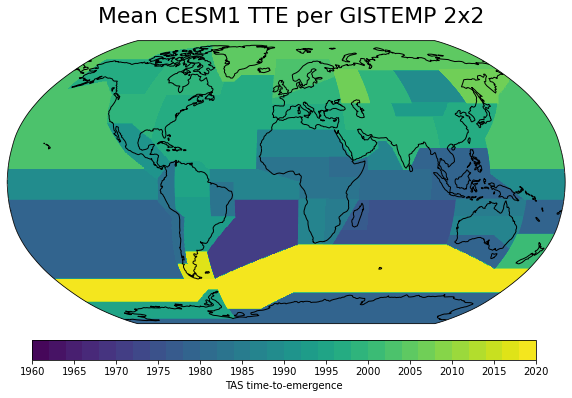

In [39]:
model_name = 'Mean CESM1 TTE per GISTEMP 2x2'
_unc_mask = cesm1_gistemp_2x2_mean_mask

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask, 60,
             transform=ccrs.PlateCarree(),levels=np.linspace(1960,2020,31))

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(1960,2020,13),
             label='TAS time-to-emergence',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

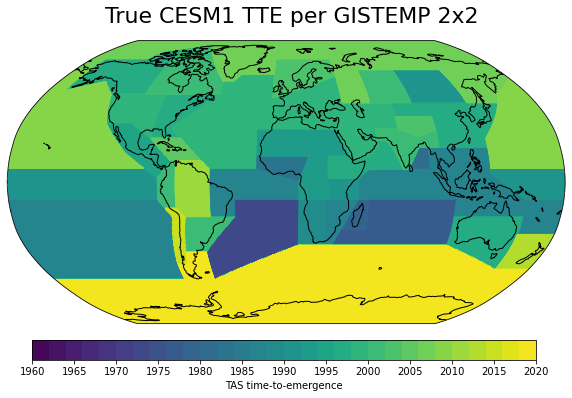

In [40]:
model_name = 'True CESM1 TTE per GISTEMP 2x2'
_unc_mask = cesm1_gistemp_2x2_true_mask

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask, 60,
             transform=ccrs.PlateCarree(),levels=np.linspace(1960,2020,31))

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(1960,2020,13),
             label='TAS time-to-emergence',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

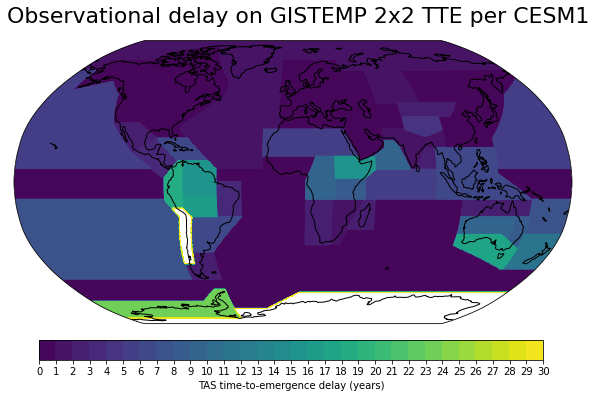

In [42]:
model_name = 'Observational delay on GISTEMP 2x2 TTE per CESM1'
_unc_mask = (cesm1_gistemp_2x2_true_mask - cesm1_gistemp_2x2_mean_mask)

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask, 60,
             transform=ccrs.PlateCarree(),levels=np.linspace(0,30,31))

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(0,30,31),
             label='TAS time-to-emergence delay (years)',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

In [44]:
cesm1_pic_trends_97_5perc.RegionName

<xarray.DataArray 'RegionName' (RegionIndex: 58)>
array(['Greenland/Iceland', 'N.W.North-America', 'N.E.North-America',
       'W.North-America', 'C.North-America', 'E.North-America',
       'N.Central-America', 'S.Central-America', 'Caribbean',
       'N.W.South-America', 'N.South-America', 'N.E.South-America',
       'South-American-Monsoon', 'S.W.South-America', 'S.E.South-America',
       'S.South-America', 'N.Europe', 'West&Central-Europe', 'E.Europe',
       'Mediterranean', 'Sahara', 'Western-Africa', 'Central-Africa',
       'N.Eastern-Africa', 'S.Eastern-Africa', 'W.Southern-Africa',
       'E.Southern-Africa', 'Madagascar', 'Russian-Arctic', 'W.Siberia',
       'E.Siberia', 'Russian-Far-East', 'W.C.Asia', 'E.C.Asia',
       'Tibetan-Plateau', 'E.Asia', 'Arabian-Peninsula', 'S.Asia',
       'S.E.Asia', 'N.Australia', 'C.Australia', 'E.Australia',
       'S.Australia', 'New-Zealand', 'E.Antarctica', 'W.Antarctica',
       'Arctic-Ocean', 'N.Pacific-Ocean', 'Equatorial.Pacific-Ocean',
       'S.Pacific-Ocean', 'N.Atlantic-Ocean', 'Equatorial.Atlantic-Ocean',
       'S.Atlantic-Ocean', 'Arabian-Sea', 'Bay-of-Bengal',
       'Equatorial.Indic-Ocean', 'S.Indic-Ocean', 'Southern-Ocean'],
      dtype=object)
Coordinates:
  * RegionIndex   (RegionIndex) int64 0 1 2 3 4 5 6 7 ... 51 52 53 54 55 56 57
    RegionName    (RegionIndex) object 'Greenland/Iceland' ... 'Southern-Ocean'
    RegionAbbrev  (RegionIndex) object 'GIC' 'NWN' 'NEN' ... 'EIO' 'SIO' 'SOO'

In [98]:
# mean_tte = gistemp_2x2_trends_50_perc

out = gistemp_2x2_trends_50_perc.sel(RegionIndex=region_index) > cesm1_pic_trends_97_5perc.sel(RegionIndex=region_index)

In [103]:
test = out.duration.where(~out).max(dim='duration')

In [33]:
def emergence_wrapper(TTE_data):
    detect_ds = TTE_data < TTE_data.duration
    duration_broad = detect_ds.duration.broadcast_like(detect_ds)
    
    emergence_ds = 1 + duration_broad.where(~detect_ds).max(dim='duration')
    
    return emergence_ds

In [34]:
emergence_LP_allvar = {}

for _var in emerge_vars:
    
    # calculate emergence
    _emergence_LP_annual_ds  = emergence_wrapper(TTE_annual_LP_all[_var])
    _emergence_LP_monthly_ds = emergence_wrapper(TTE_monthly_LP_all[_var])
    
    # Merge the monthly and annual emergence values.
    _emergence_LP_all = xr.merge([_emergence_LP_monthly_ds,_emergence_LP_annual_ds.assign_coords({'month':13}).expand_dims('month',axis=-1)])['duration']
    
    emergence_LP_allvar[_var] = _emergence_LP_all

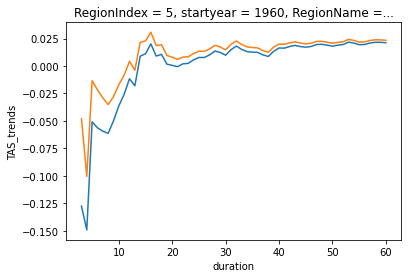

In [70]:
gistemp_2x2_trends_2_5perc.sel(RegionIndex=5).plot()

gistemp_2x2_trends_97_5perc.sel(RegionIndex=5).plot()

In [65]:
test_oerc #.plot()

<xarray.DataArray 'TAS_trends' (duration: 58, RegionIndex: 58)>
dask.array<vectorize_nanpercentile, shape=(58, 58), dtype=float64, chunksize=(58, 58), chunktype=numpy.ndarray>
Coordinates:
  * RegionIndex   (RegionIndex) int64 0 1 2 3 4 5 6 7 ... 51 52 53 54 55 56 57
    startyear     int64 1960
  * duration      (duration) int64 3 4 5 6 7 8 9 10 ... 53 54 55 56 57 58 59 60
    RegionName    (RegionIndex) object dask.array<chunksize=(58,), meta=np.ndarray>
    RegionAbbrev  (RegionIndex) object dask.array<chunksize=(58,), meta=np.ndarray>

In [59]:
hadcrut5_trends_all

<xarray.DataArray 'TAS_trends' (duration: 60, startyear: 61, realization: 200, RegionIndex: 58)>
[42456000 values with dtype=float64]
Coordinates:
  * RegionIndex   (RegionIndex) int64 0 1 2 3 4 5 6 7 ... 51 52 53 54 55 56 57
  * startyear     (startyear) int64 1960 1961 1962 1963 ... 2017 2018 2019 2020
  * realization   (realization) int64 1 2 3 4 5 6 7 ... 195 196 197 198 199 200
  * duration      (duration) int64 3 4 5 6 7 8 9 10 ... 55 56 57 58 59 60 61 62
    RegionName    (RegionIndex) object ...
    RegionAbbrev  (RegionIndex) object ...

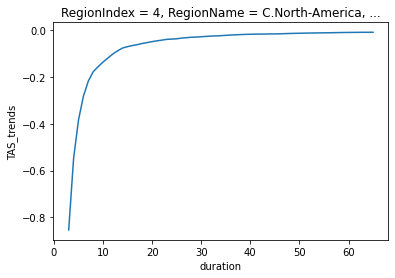

In [20]:
trends_2_5perc.sel(RegionIndex=4).plot()

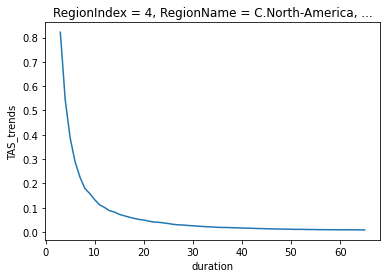

In [21]:
trends_97_5perc.sel(RegionIndex=4).plot()

## Old Code

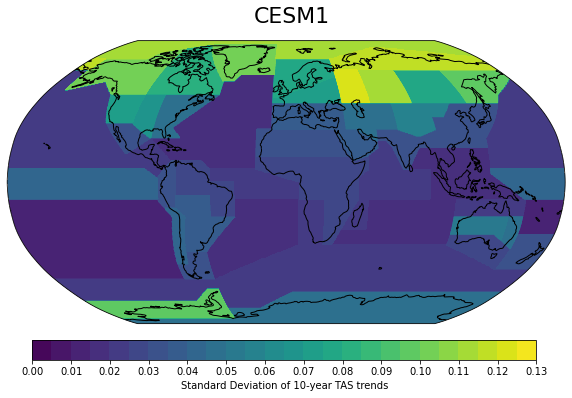

In [48]:
model_name = 'CESM1'
_unc_mask = cesm1_unc_mask

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask, 60,
             transform=ccrs.PlateCarree(),levels=np.linspace(0,0.13,27))

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(0,0.13,14),
             label='Standard Deviation of 10-year TAS trends',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

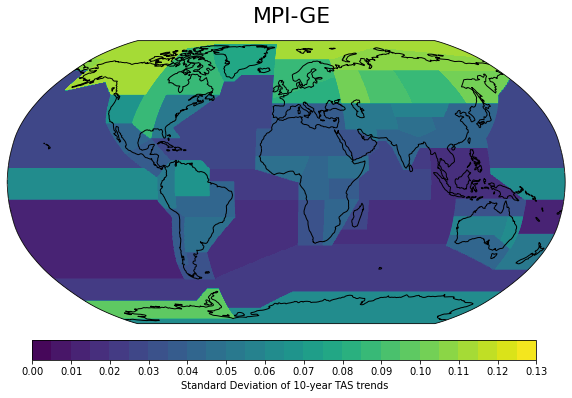

In [97]:
model_name = 'MPI-GE'
_unc_mask = mpi_unc_mask

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask, 60,
             transform=ccrs.PlateCarree(),levels=np.linspace(0,0.13,27))

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(0,0.13,14),
             label='Standard Deviation of 10-year TAS trends',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

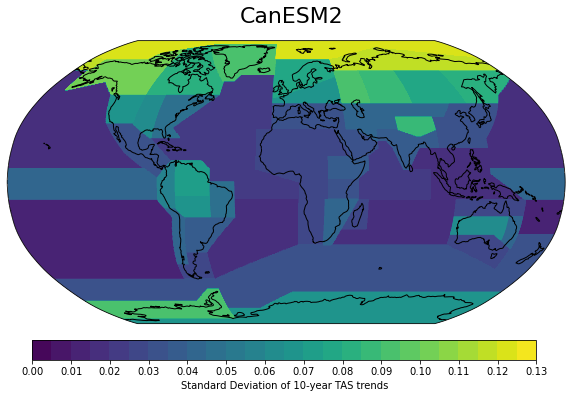

In [98]:
model_name = 'CanESM2'
_unc_mask = canesm2_unc_mask

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask, 60,
             transform=ccrs.PlateCarree(),levels=np.linspace(0,0.13,27))

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(0,0.13,14),
             label='Standard Deviation of 10-year TAS trends',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

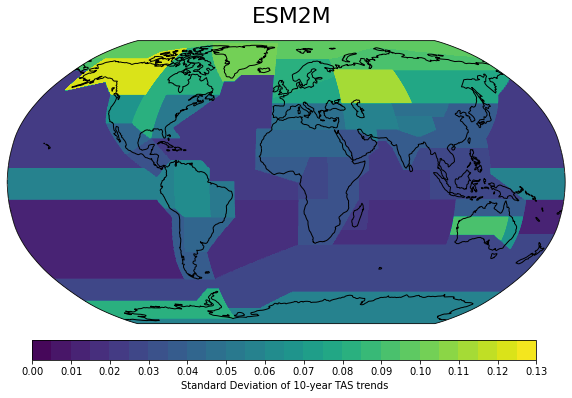

In [99]:
model_name = 'ESM2M'
_unc_mask = esm2m_unc_mask

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask, 60,
             transform=ccrs.PlateCarree(),levels=np.linspace(0,0.13,27))

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(0,0.13,14),
             label='Standard Deviation of 10-year TAS trends',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()